In [8]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_darrays as uda
import datetime
# import salem
# from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
import shapely.geometry as shpg
import glob
import pickle as pkl
import os
from scipy.stats import binned_statistic_2d
from scipy import stats
from endgame import hist2d



pylab.rcParams['figure.figsize'] = (10., 5.)
%matplotlib inline

In [7]:
cd ..

/home/ck/pythonWorkspace


In [9]:
MREGIONS = {'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (5,9), (1,12)], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (11,3), (11,3)], # 10
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (5,9), (1,12)], # 7
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (5,9), (1,12)], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9, (11,3), (1,5), (1,12)], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (11,3), (1,5), (1,12)] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17
 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), (5,9), (1,12)] # # 18

}

In [37]:
rdics = {}
for regs in MREGIONS.keys():
    for ids, y in enumerate(range(2000,2021)):
      
        test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/save_files_v2/'+regs+'_mcs_tracks_final_'+str(y)+'*.csv')[0])
        if ids == 0:
            test2 = pd.DataFrame(test)
        else :
            test2 = pd.concat([test2, test])
    rdics[regs] = test2

In [38]:
print(list(rdics['WAf'].keys()))

['track_duration', 'start_status', 'end_status', 'start_basetime', 'end_basetime', 'start_split_cloudnumber', 'end_merge_cloudnumber', 'base_time', 'meanlat', 'meanlon', 'area', 'cloudnumber', 'track_status', 'track_interruptions', 'core_area', 'cold_area', 'corecold_mintb', 'corecold_meantb', 'core_meantb', 'mcs_duration', 'mcs_status', 'ccs_area', 'pf_npf', 'pf_lon1', 'pf_lon2', 'pf_lon3', 'pf_lat1', 'pf_lat2', 'pf_lat3', 'pf_area1', 'pf_area2', 'pf_area3', 'pf_rainrate1', 'pf_rainrate2', 'pf_rainrate3', 'pf_majoraxis1', 'pf_majoraxis2', 'pf_majoraxis3', 'pf_minoraxis1', 'pf_minoraxis2', 'pf_minoraxis3', 'pf_aspectratio1', 'pf_aspectratio2', 'pf_aspectratio3', 'pf_orientation1', 'pf_orientation2', 'pf_orientation3', 'pf_eccentricity1', 'pf_eccentricity2', 'pf_eccentricity3', 'pf_lon_centroid1', 'pf_lon_centroid2', 'pf_lon_centroid3', 'pf_lat_centroid1', 'pf_lat_centroid2', 'pf_lat_centroid3', 'pf_lon_weightedcentroid1', 'pf_lon_weightedcentroid2', 'pf_lon_weightedcentroid3', 'pf_lat_

In [39]:
for regs in MREGIONS.keys():
    print(regs, len(rdics[regs]['pf_rainrate1']))

WAf 473253
SAf 103692
india 338439
china 44288
australia 88237
sub_SA 183880
GPlains 58007


In [26]:
for regs in MREGIONS.keys():
    creg = rdics[regs]
    rdics[regs] = creg[(creg['lt_hour'] >=15) & (creg['lt_hour'] <=20)]

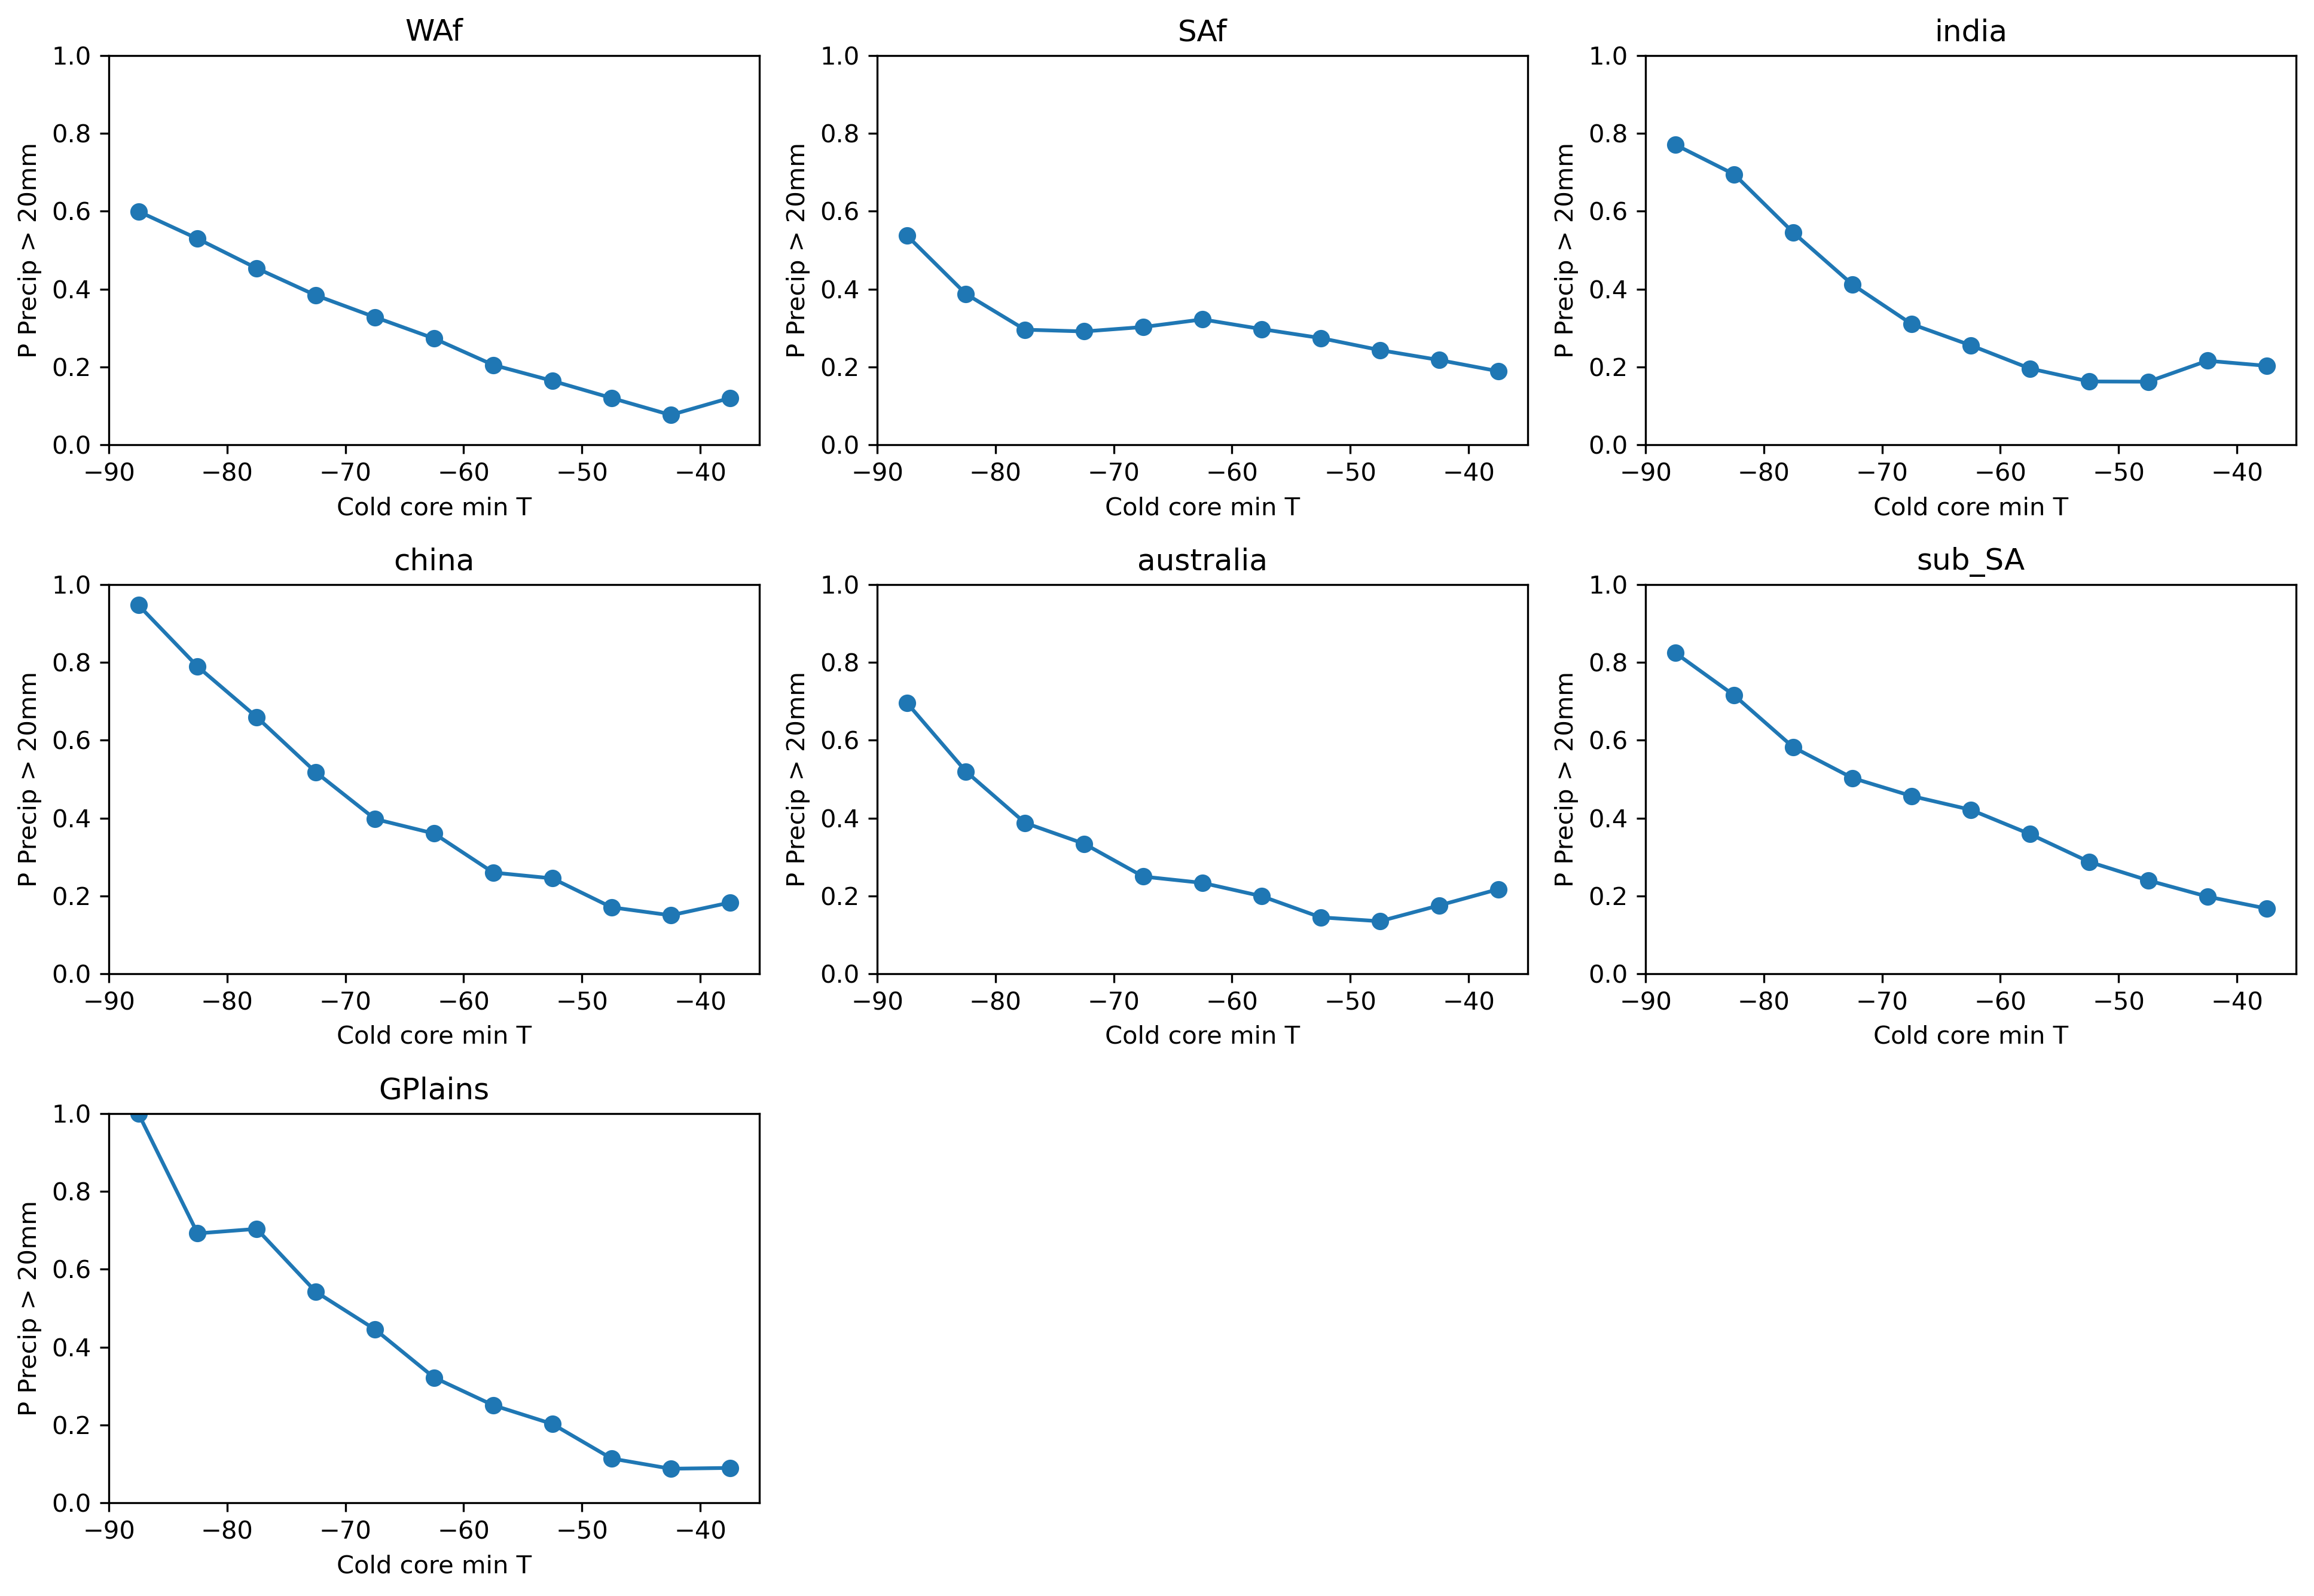

In [27]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    outdic = hist2d.var2_binning_threshold((rdics[regs]['corecold_mintb']-273.15).values, (rdics[regs]['pf_maxrainrate1']).values, np.arange(-90,-30,5), gt=20)
    plt.plot(outdic['xbins'], outdic['y'], '-o')
    plt.title(regs)
    ax.set_ylim(0,1)
    plt.ylabel('P Precip > 20mm')
    plt.xlabel('Cold core min T')
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/20mm_precip_vs_CC_minT.jpg')

In [28]:
from utils import u_statistics as u_stats

18
16
13
10
9
22
24


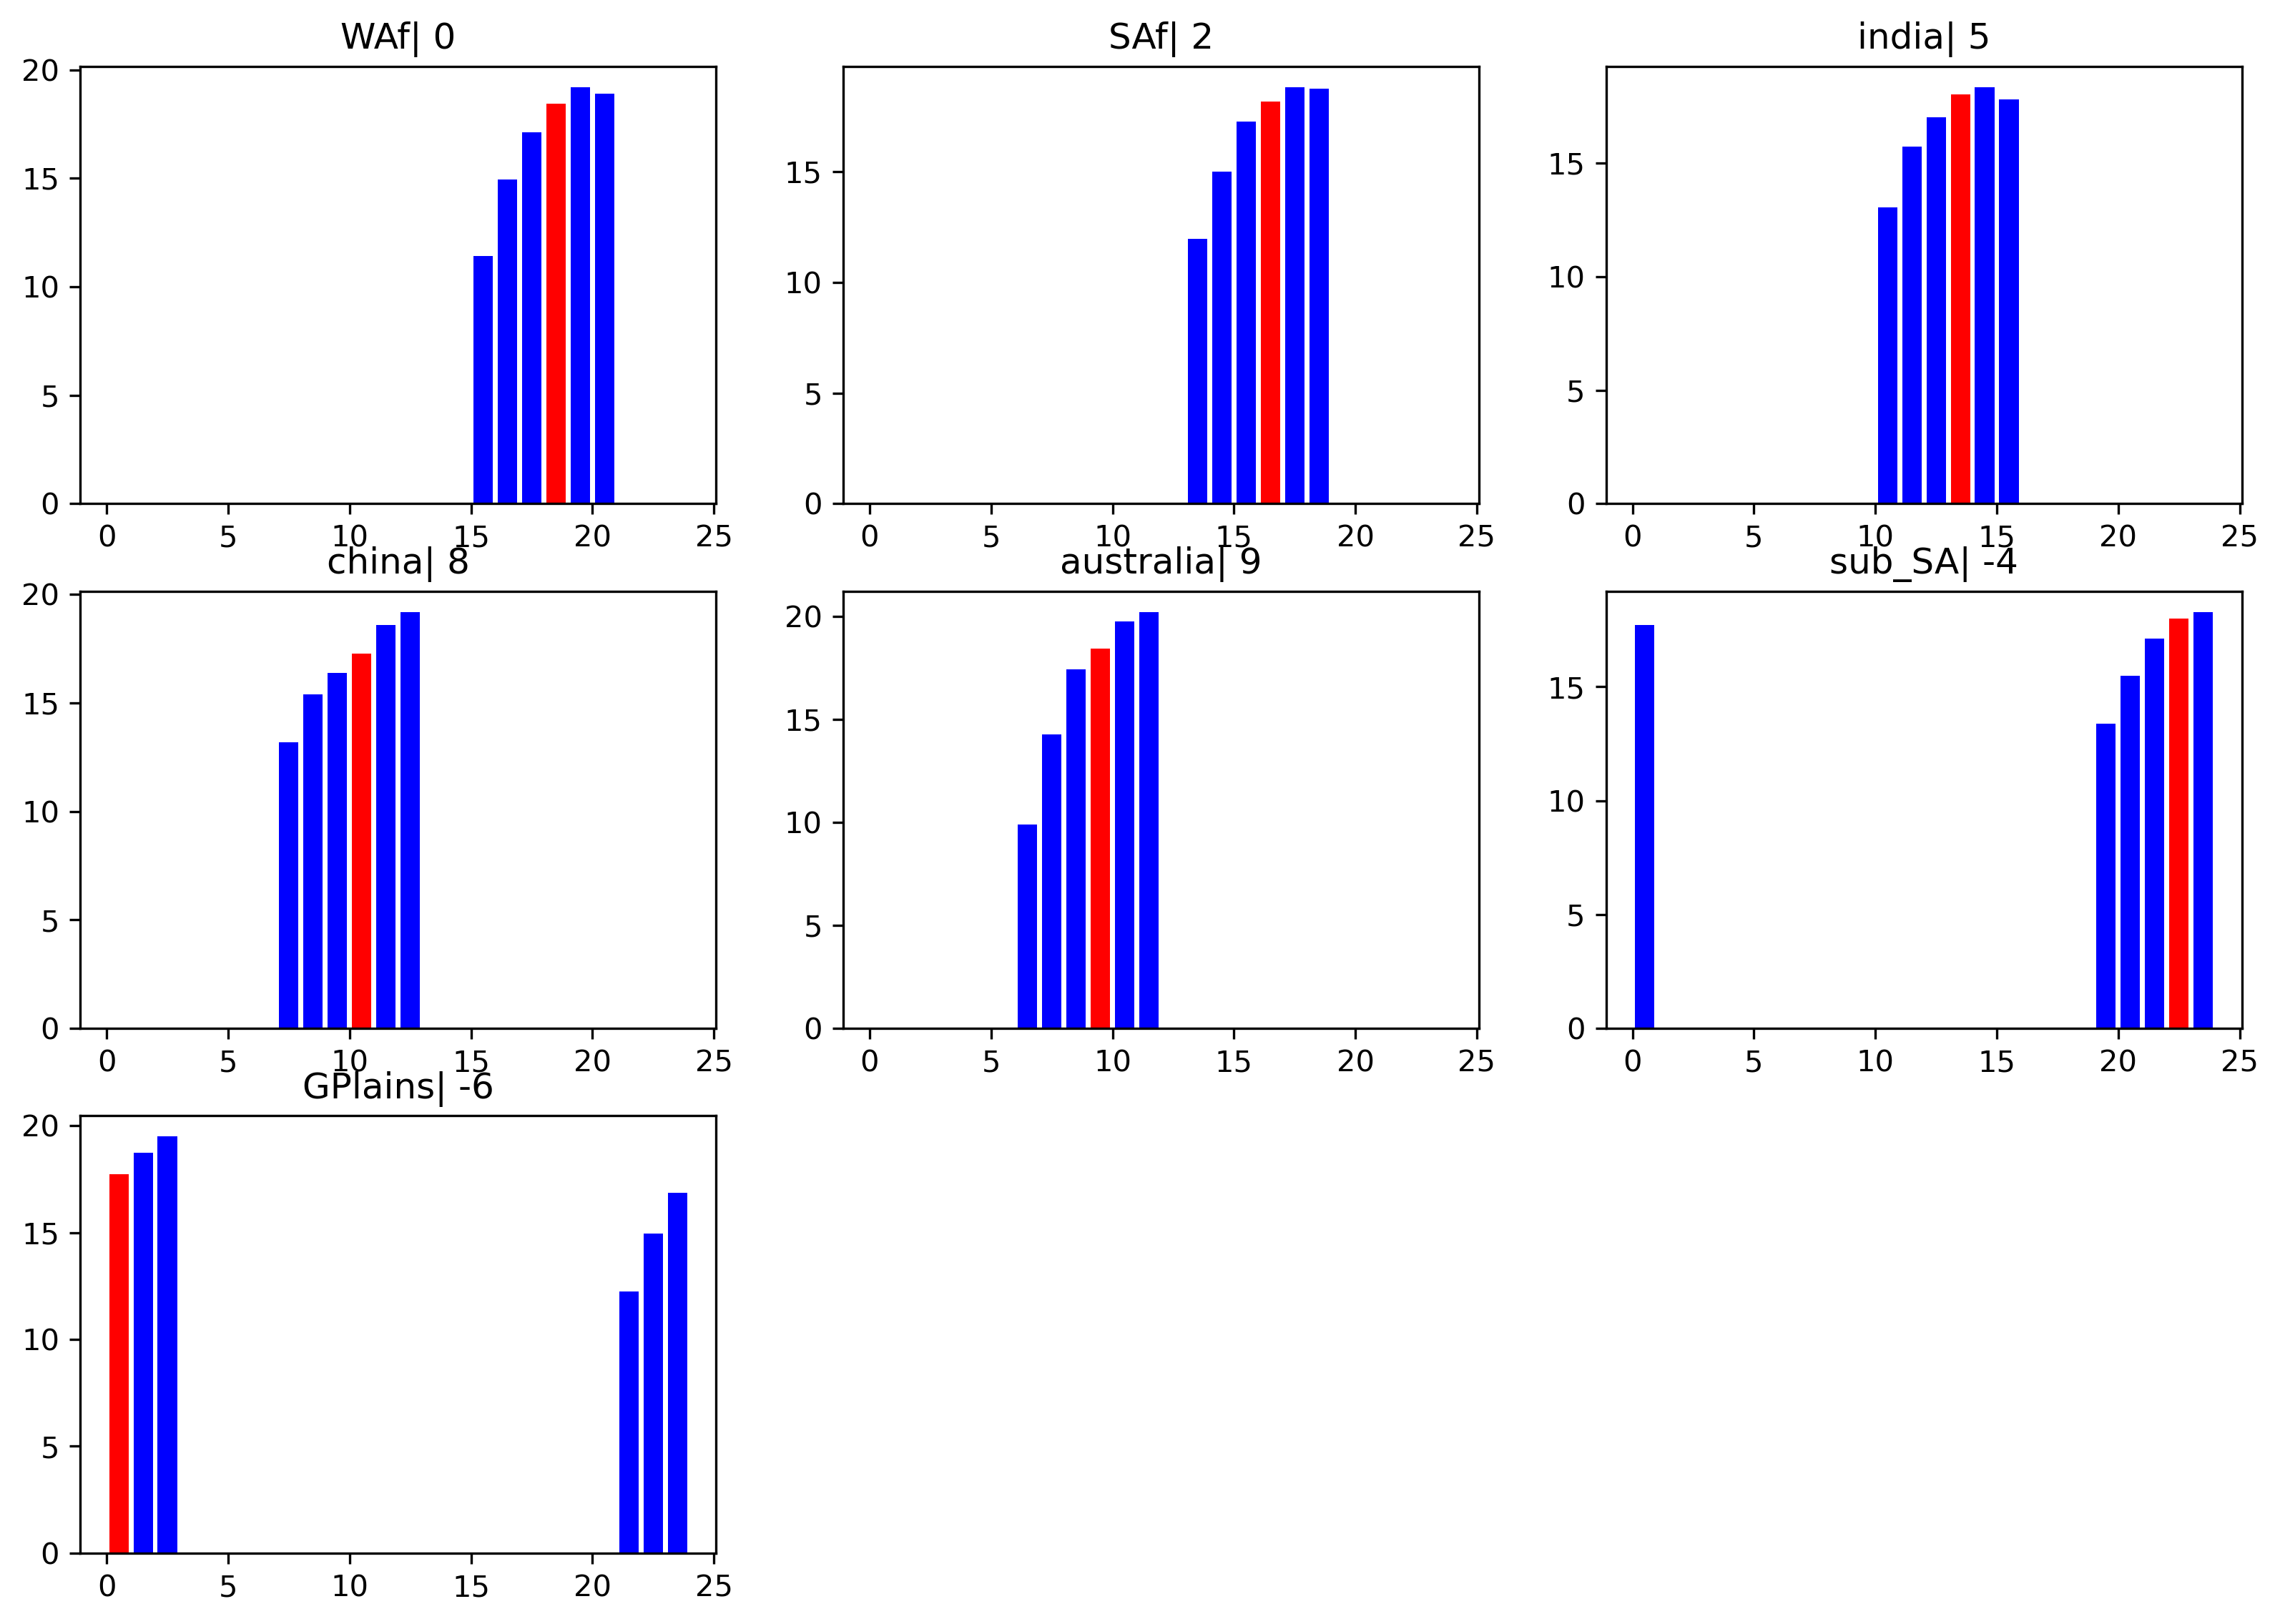

In [30]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    
    SENSOP = 10
    TRACKTIME = 0
    h = 16
    h1 = 17
    h2 = 18
    AREA = 5000
    
    inmask =   ((pick['lt_init_hour'] >= SENSOP+2) & (pick['tracktime'] >= TRACKTIME)  &\
                   ((pick['lt_hour'] >=15) & (pick['lt_hour'] <=20)) & \
                    (pick['pf_landfrac'] > 0.95)  & (pick['pf_area1'] > AREA)) & np.isfinite(pick['pf_lat1'])
    
    pick = pick[inmask]
    
    
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['utc_hour'], bins=np.arange(0,25))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
    ispos = int(np.where(mid_bin==18.5)[0])
    secpos = int(np.where(mid_bin==13.5)[0])
    firstpos = int(np.where(mid_bin==10.5)[0])
    #minpos = ispos-(MREGIONS[regs])[2]
    #ipdb.set_trace()
    minpos = ispos-(MREGIONS[regs])[2]
    miinpos = firstpos - (MREGIONS[regs])[2]
    miiinpos = secpos - (MREGIONS[regs])[2]
    print(minpos)
    if minpos == 24:
        minpos=0
    
    colors[minpos] = 'r'  # 1800
    colors[miinpos] = 'turquoise' # 1100
    colors[miiinpos] = 'purple' # 1400
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))


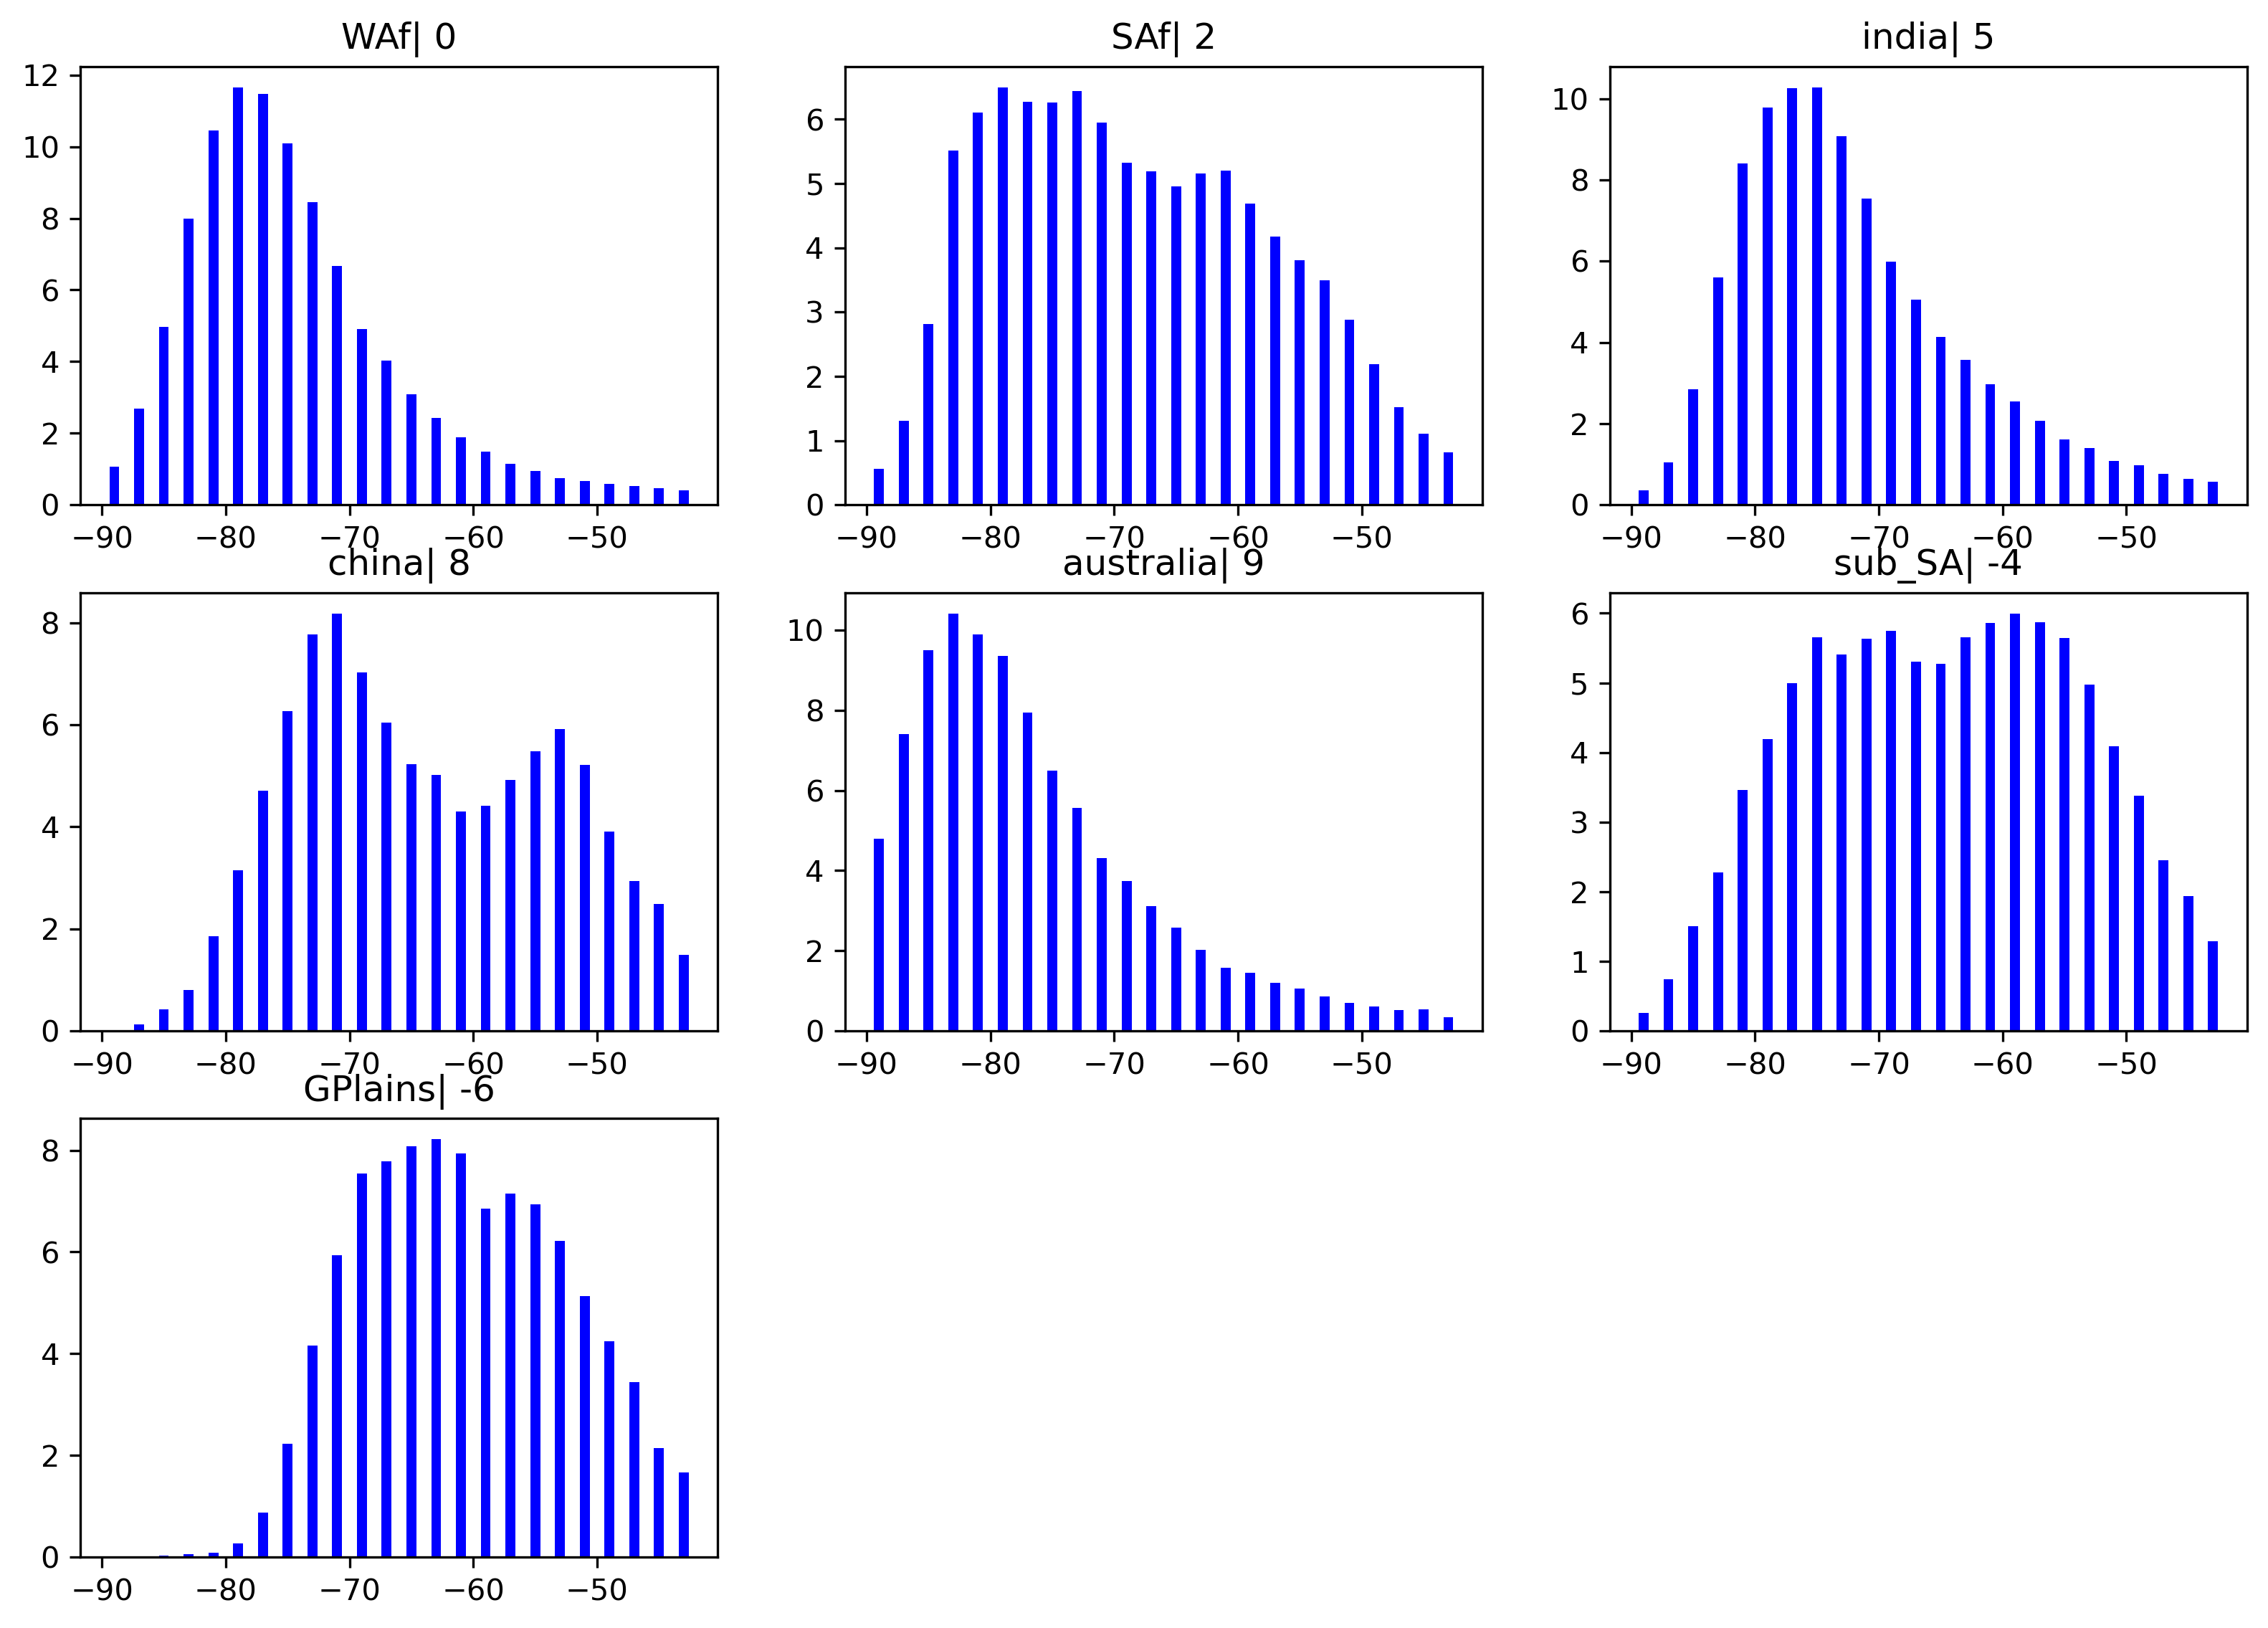

In [31]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]

    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['corecold_mintb']-273.15, bins=np.arange(-90,-40,2))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

Text(0.5, 1.0, 'Minimum storm temperature')

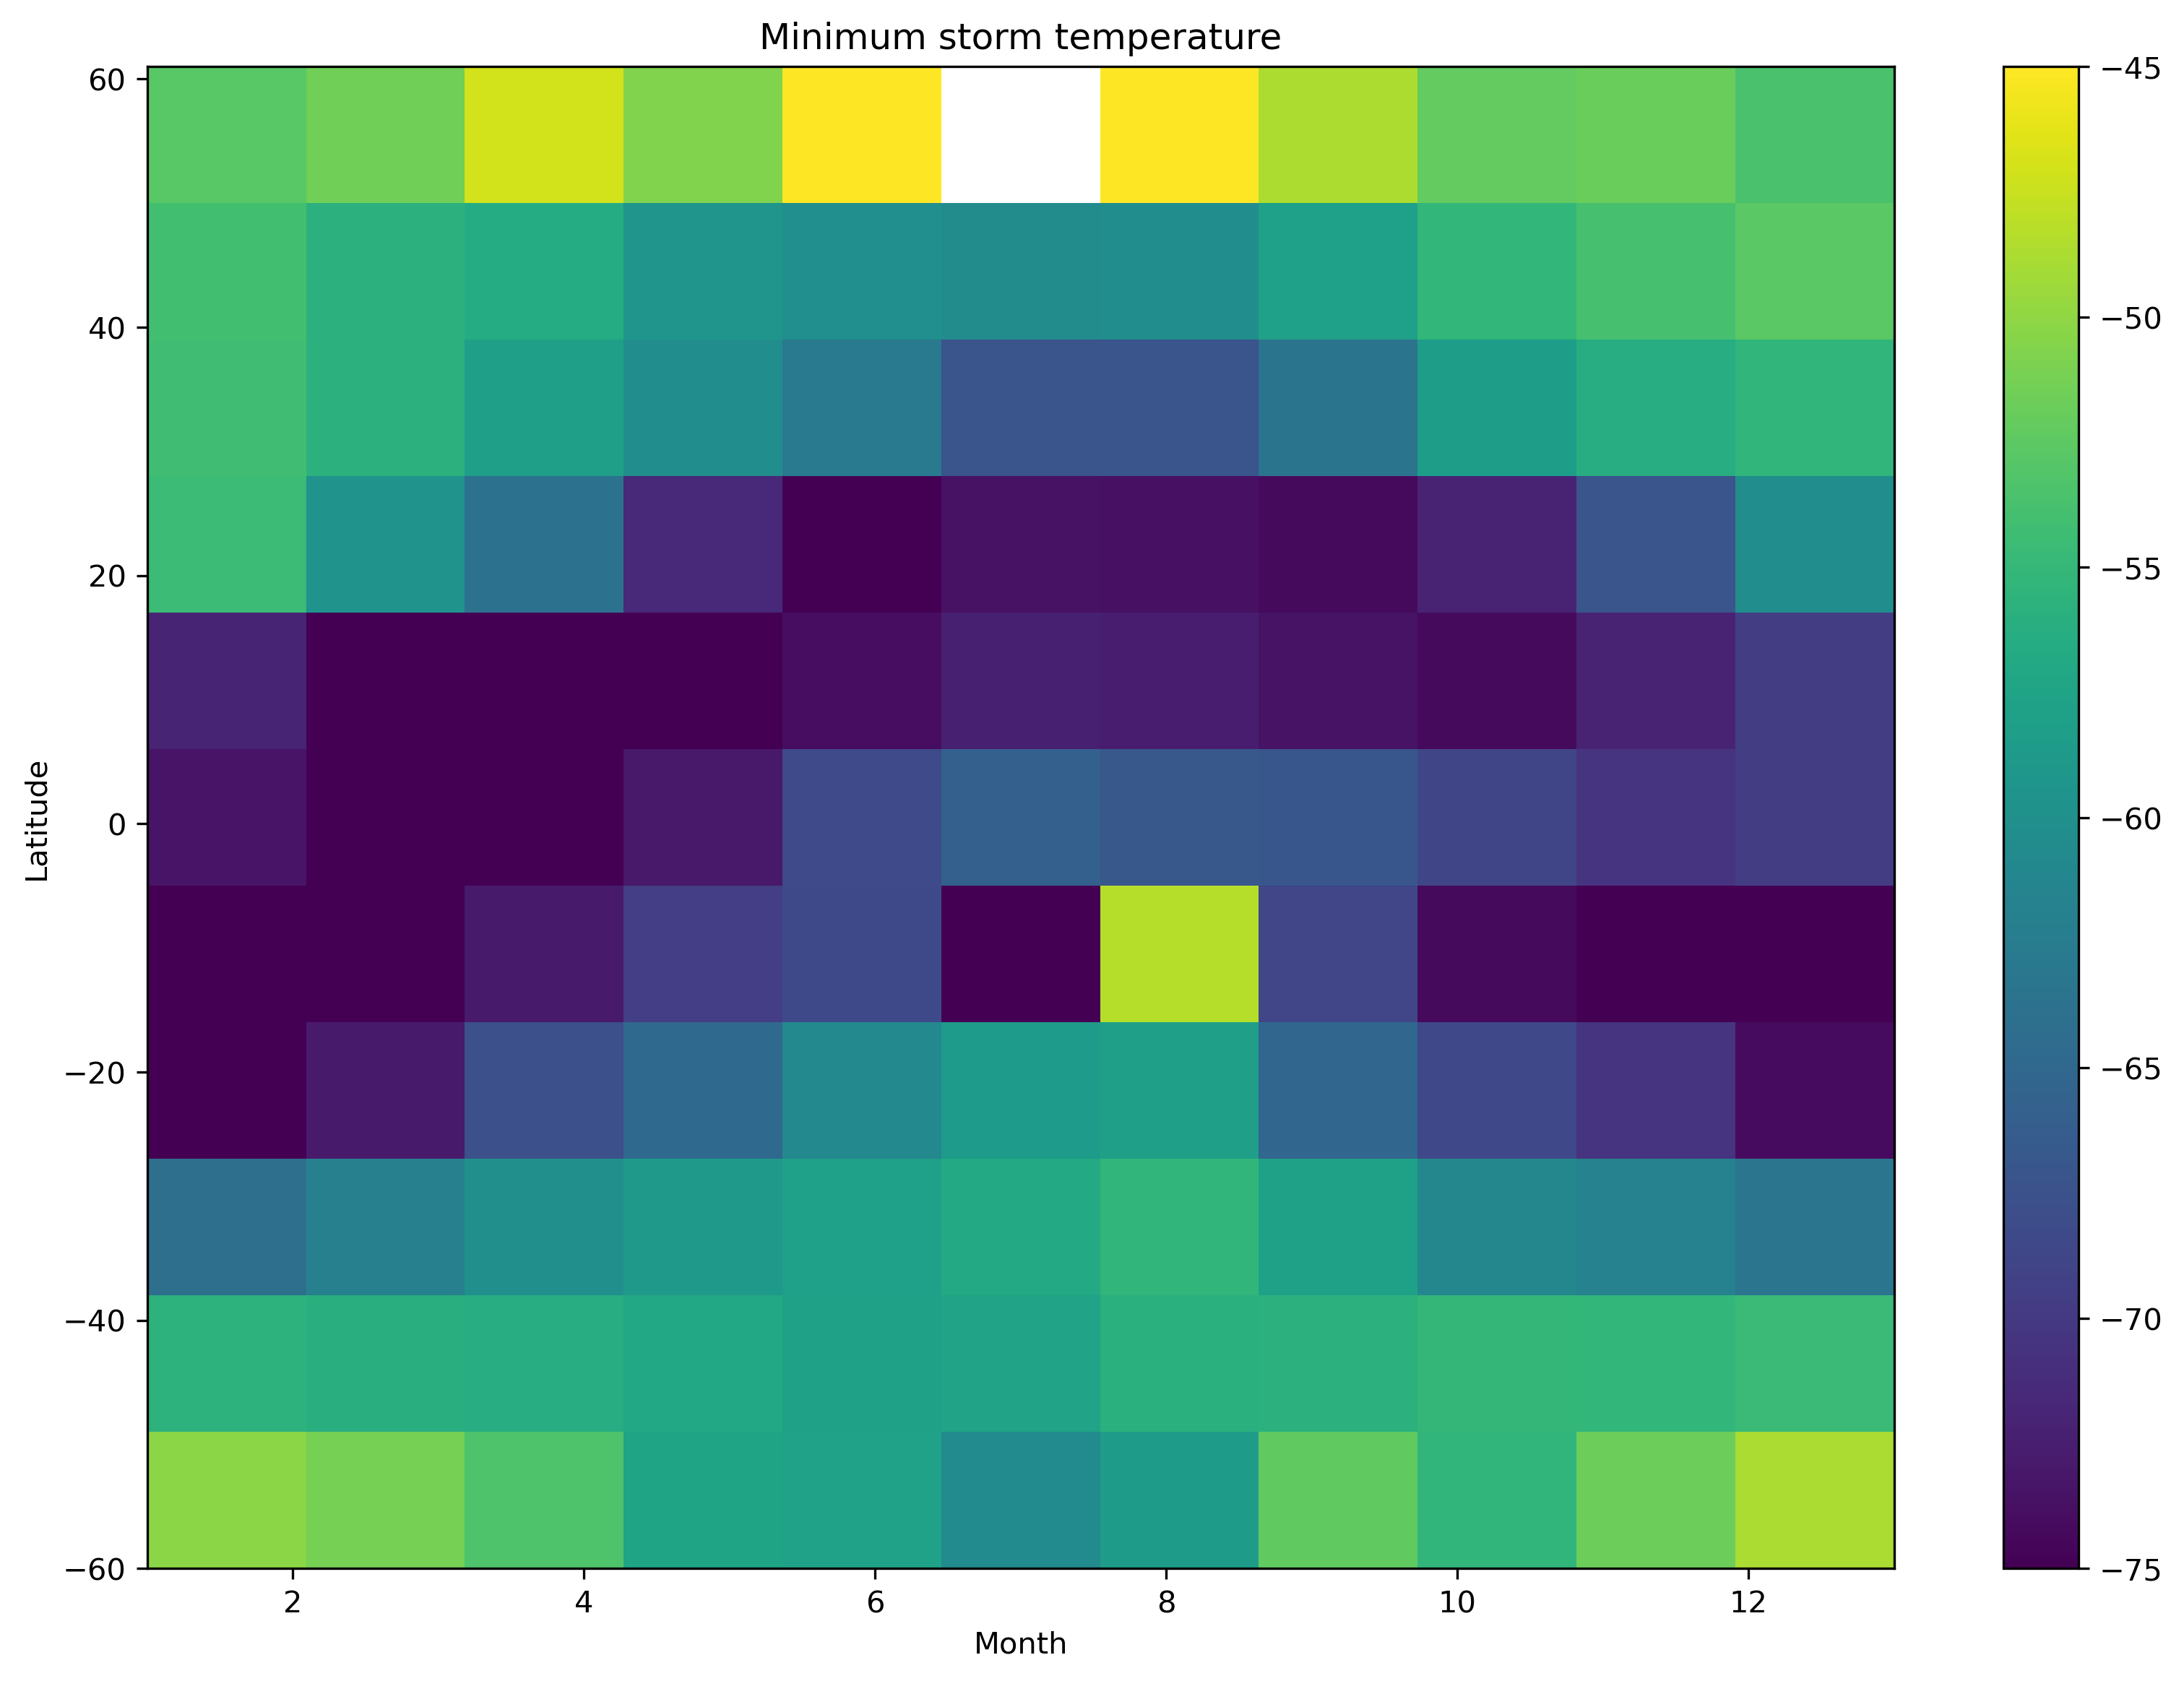

In [32]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['utc_month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['corecold_mintb']-273.15)
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-75, vmax=-45) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')
plt.title('Minimum storm temperature')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
#f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_mixed.jpg')

Text(0.5, 0, 'Month')

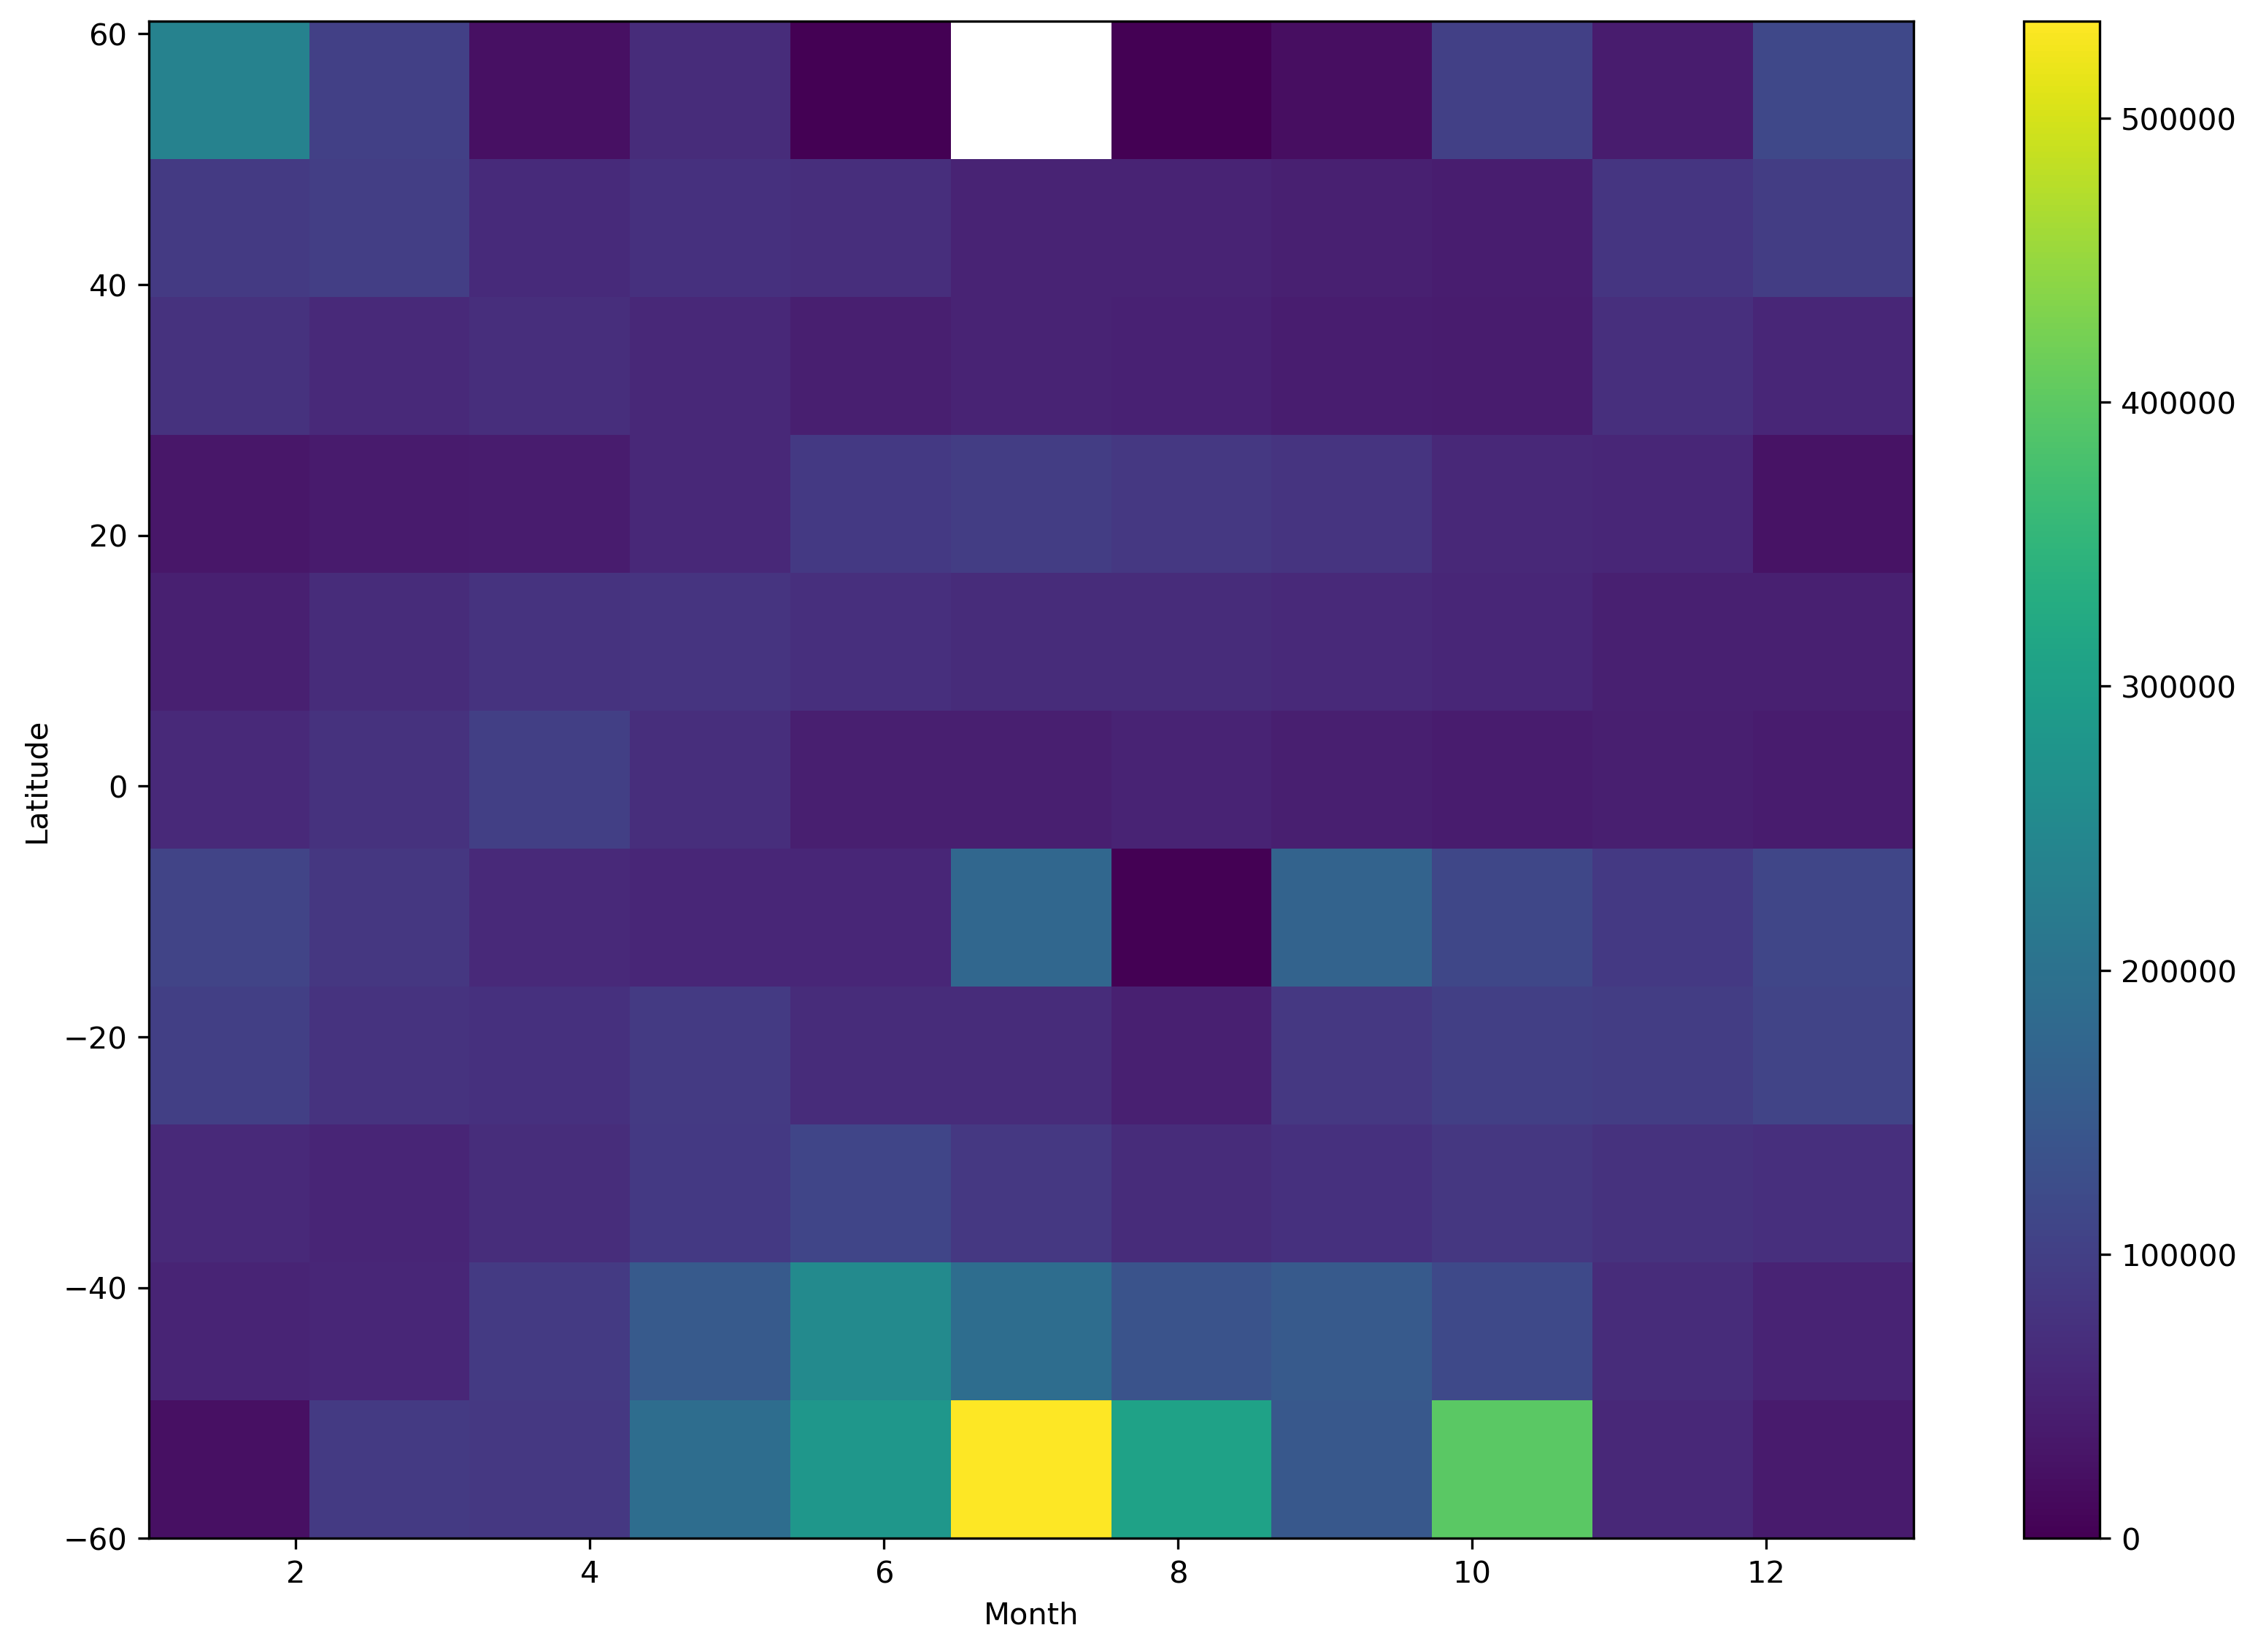

In [33]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['utc_month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['core_area'])
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis') #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
#f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_ccsArea.jpg')

In [34]:
import windrose 
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.projections import register_projection

register_projection(WindroseAxes)
color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

from utils import u_met

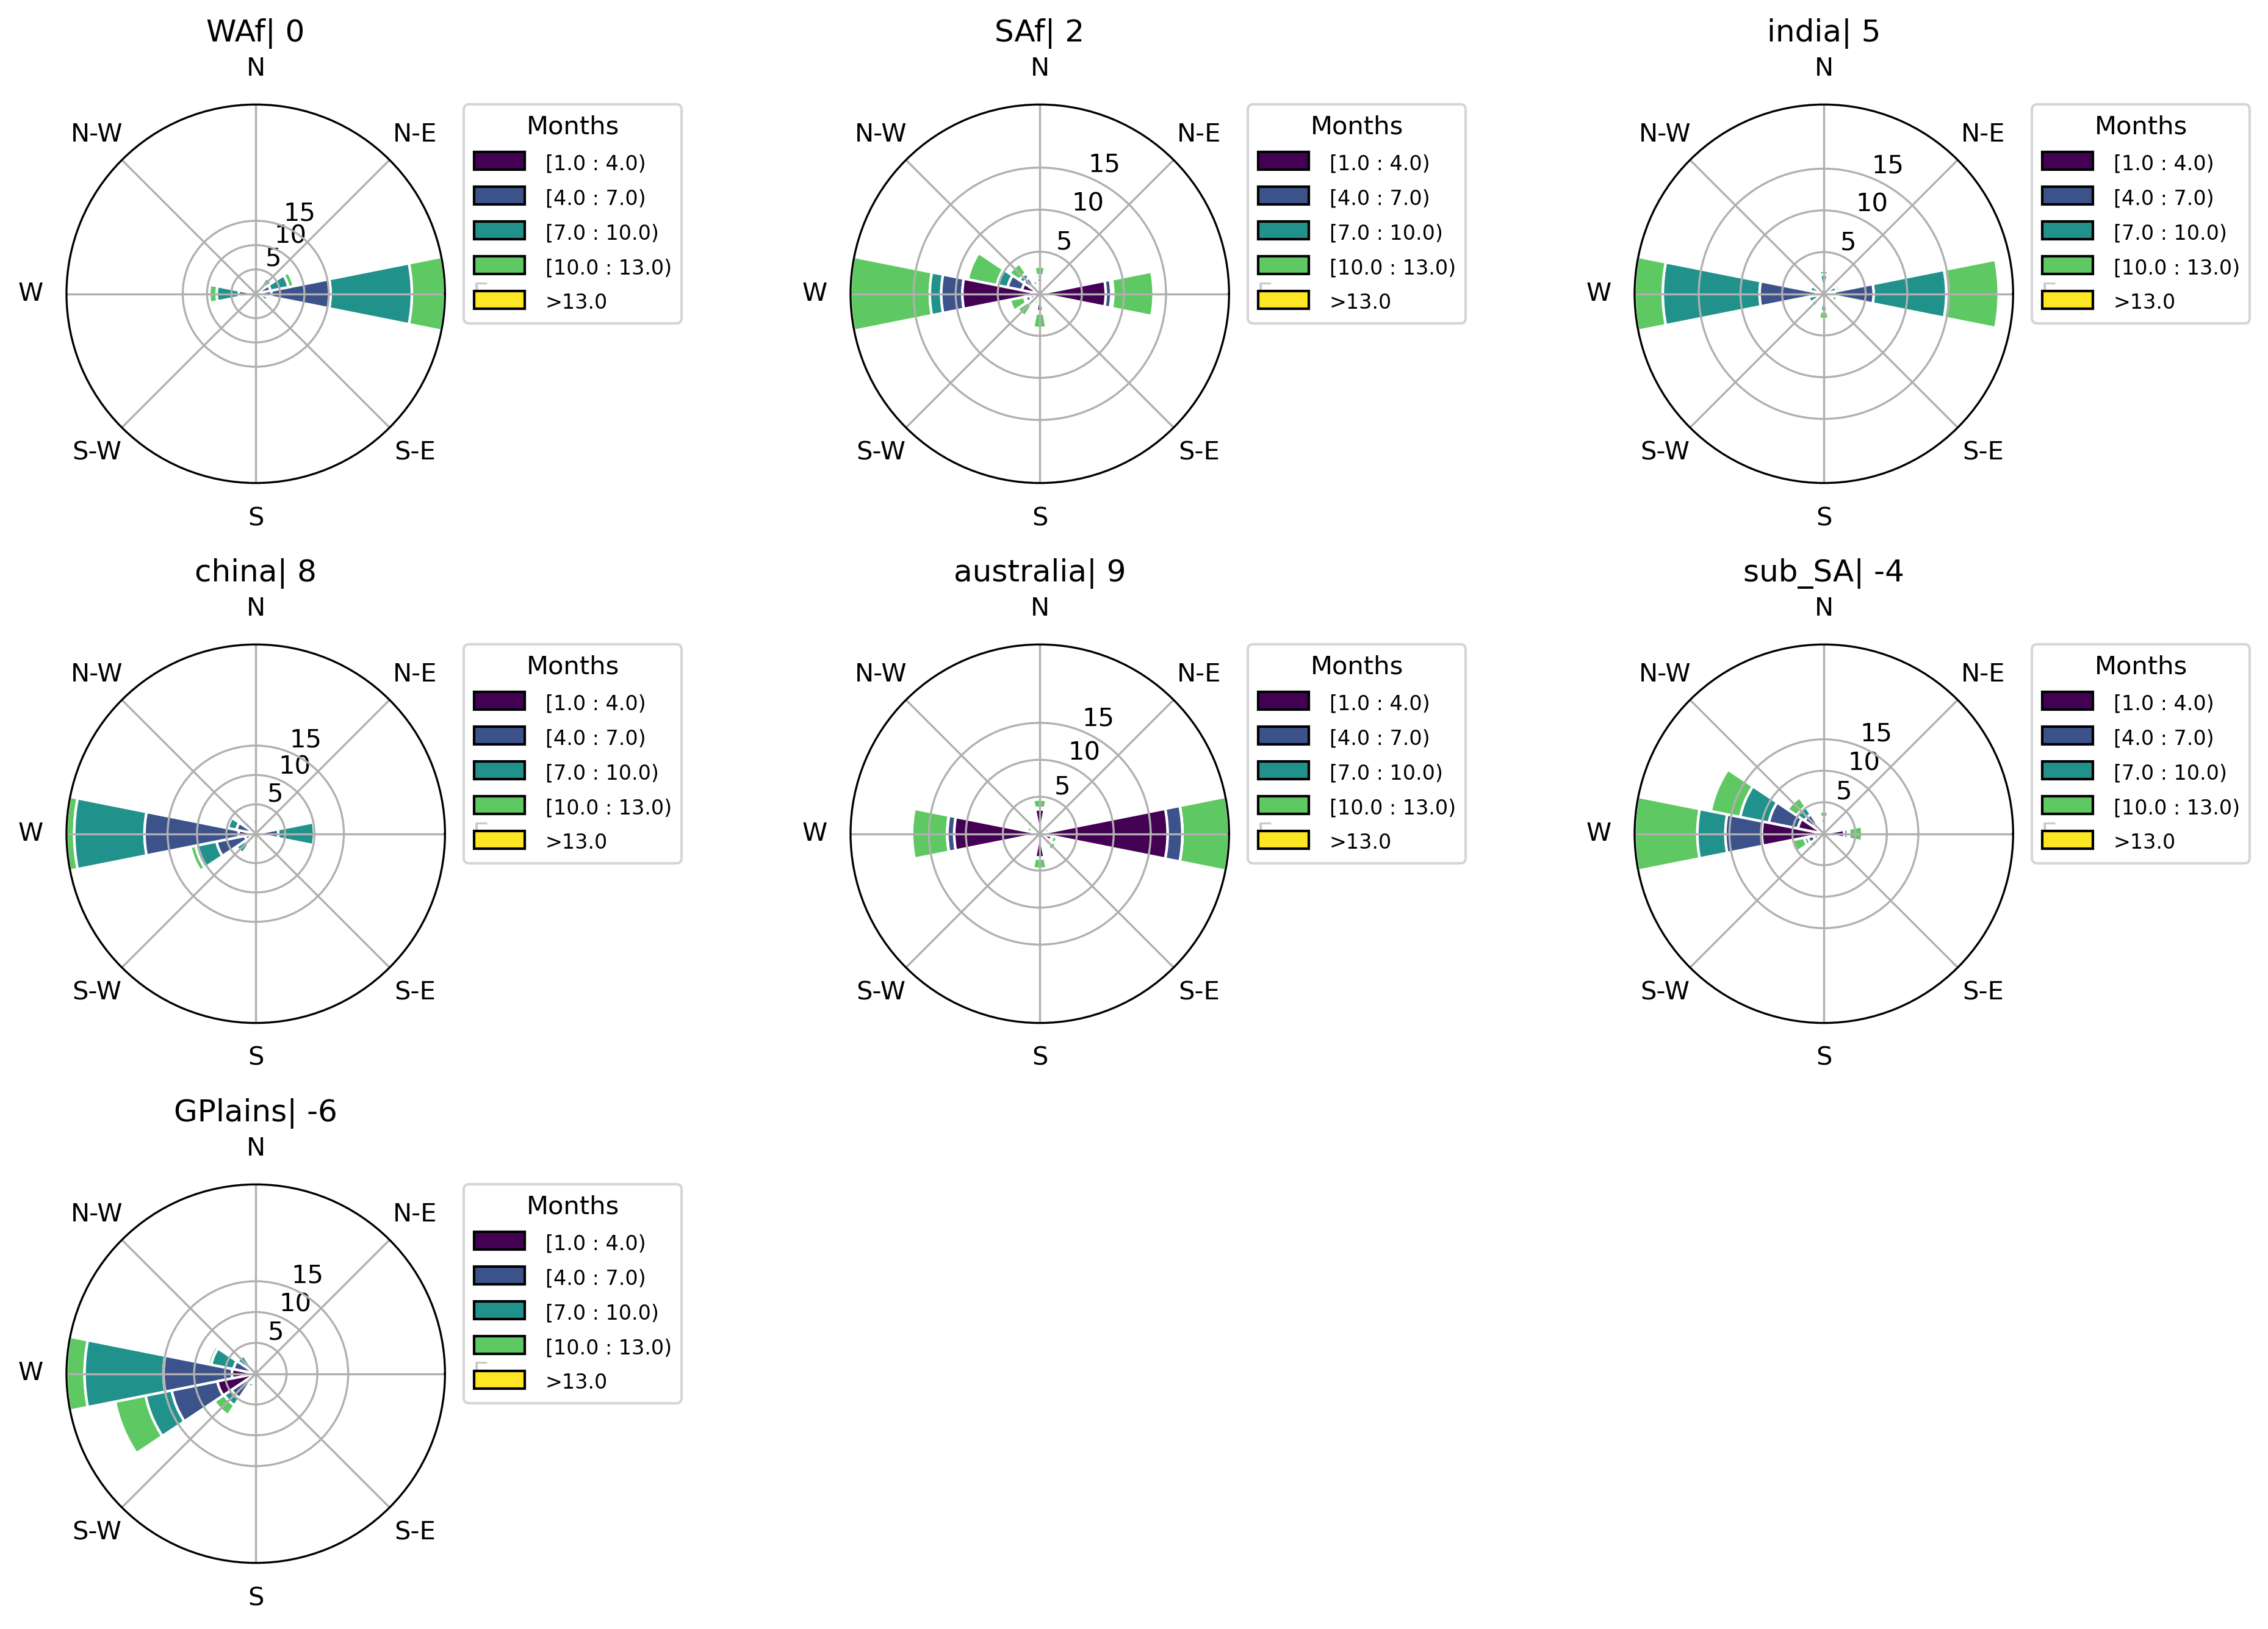

In [40]:
MREGIONS = {'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (5,9), (1,12)], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (11,3), (11,3)], # 10
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (5,9), (1,12)], # 7
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (5,9), (1,12)], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9, (11,3), (1,5), (1,12)], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (11,3), (1,5), (1,12)] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17
 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), (5,9), (1,12)] # # 18

}

f= plt.figure(figsize=(13,9), dpi=300)
maxval = [45,30,25,40,30,35,40]

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1,  projection='windrose')
    
    pick = (rdics[regs])
    #pick = pick[(pick['utc_month']>=11) | (pick['utc_month']<=2)]

    umean = (pick['movement_distance_x'])
    vmean = (pick['movement_distance_y'])
    
    ws, avg_wd = u_met.u_v_to_ws_wd(umean,vmean)
    
    direct = avg_wd
    
    #####################
    ws_array2 = pick['utc_month']  #np.array(wsin.flatten())
    wd_array2 = direct

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[1,4,7,10,13])  #, colors=color_s[0:5]
    ax.set_yticks(np.arange(5, 20, step=5))
    ax.set_yticklabels(np.arange(5, 20, step=5))



    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
    ax.set_legend(title = 'Months', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/storm_direction_windrose_datasetV2.jpg')

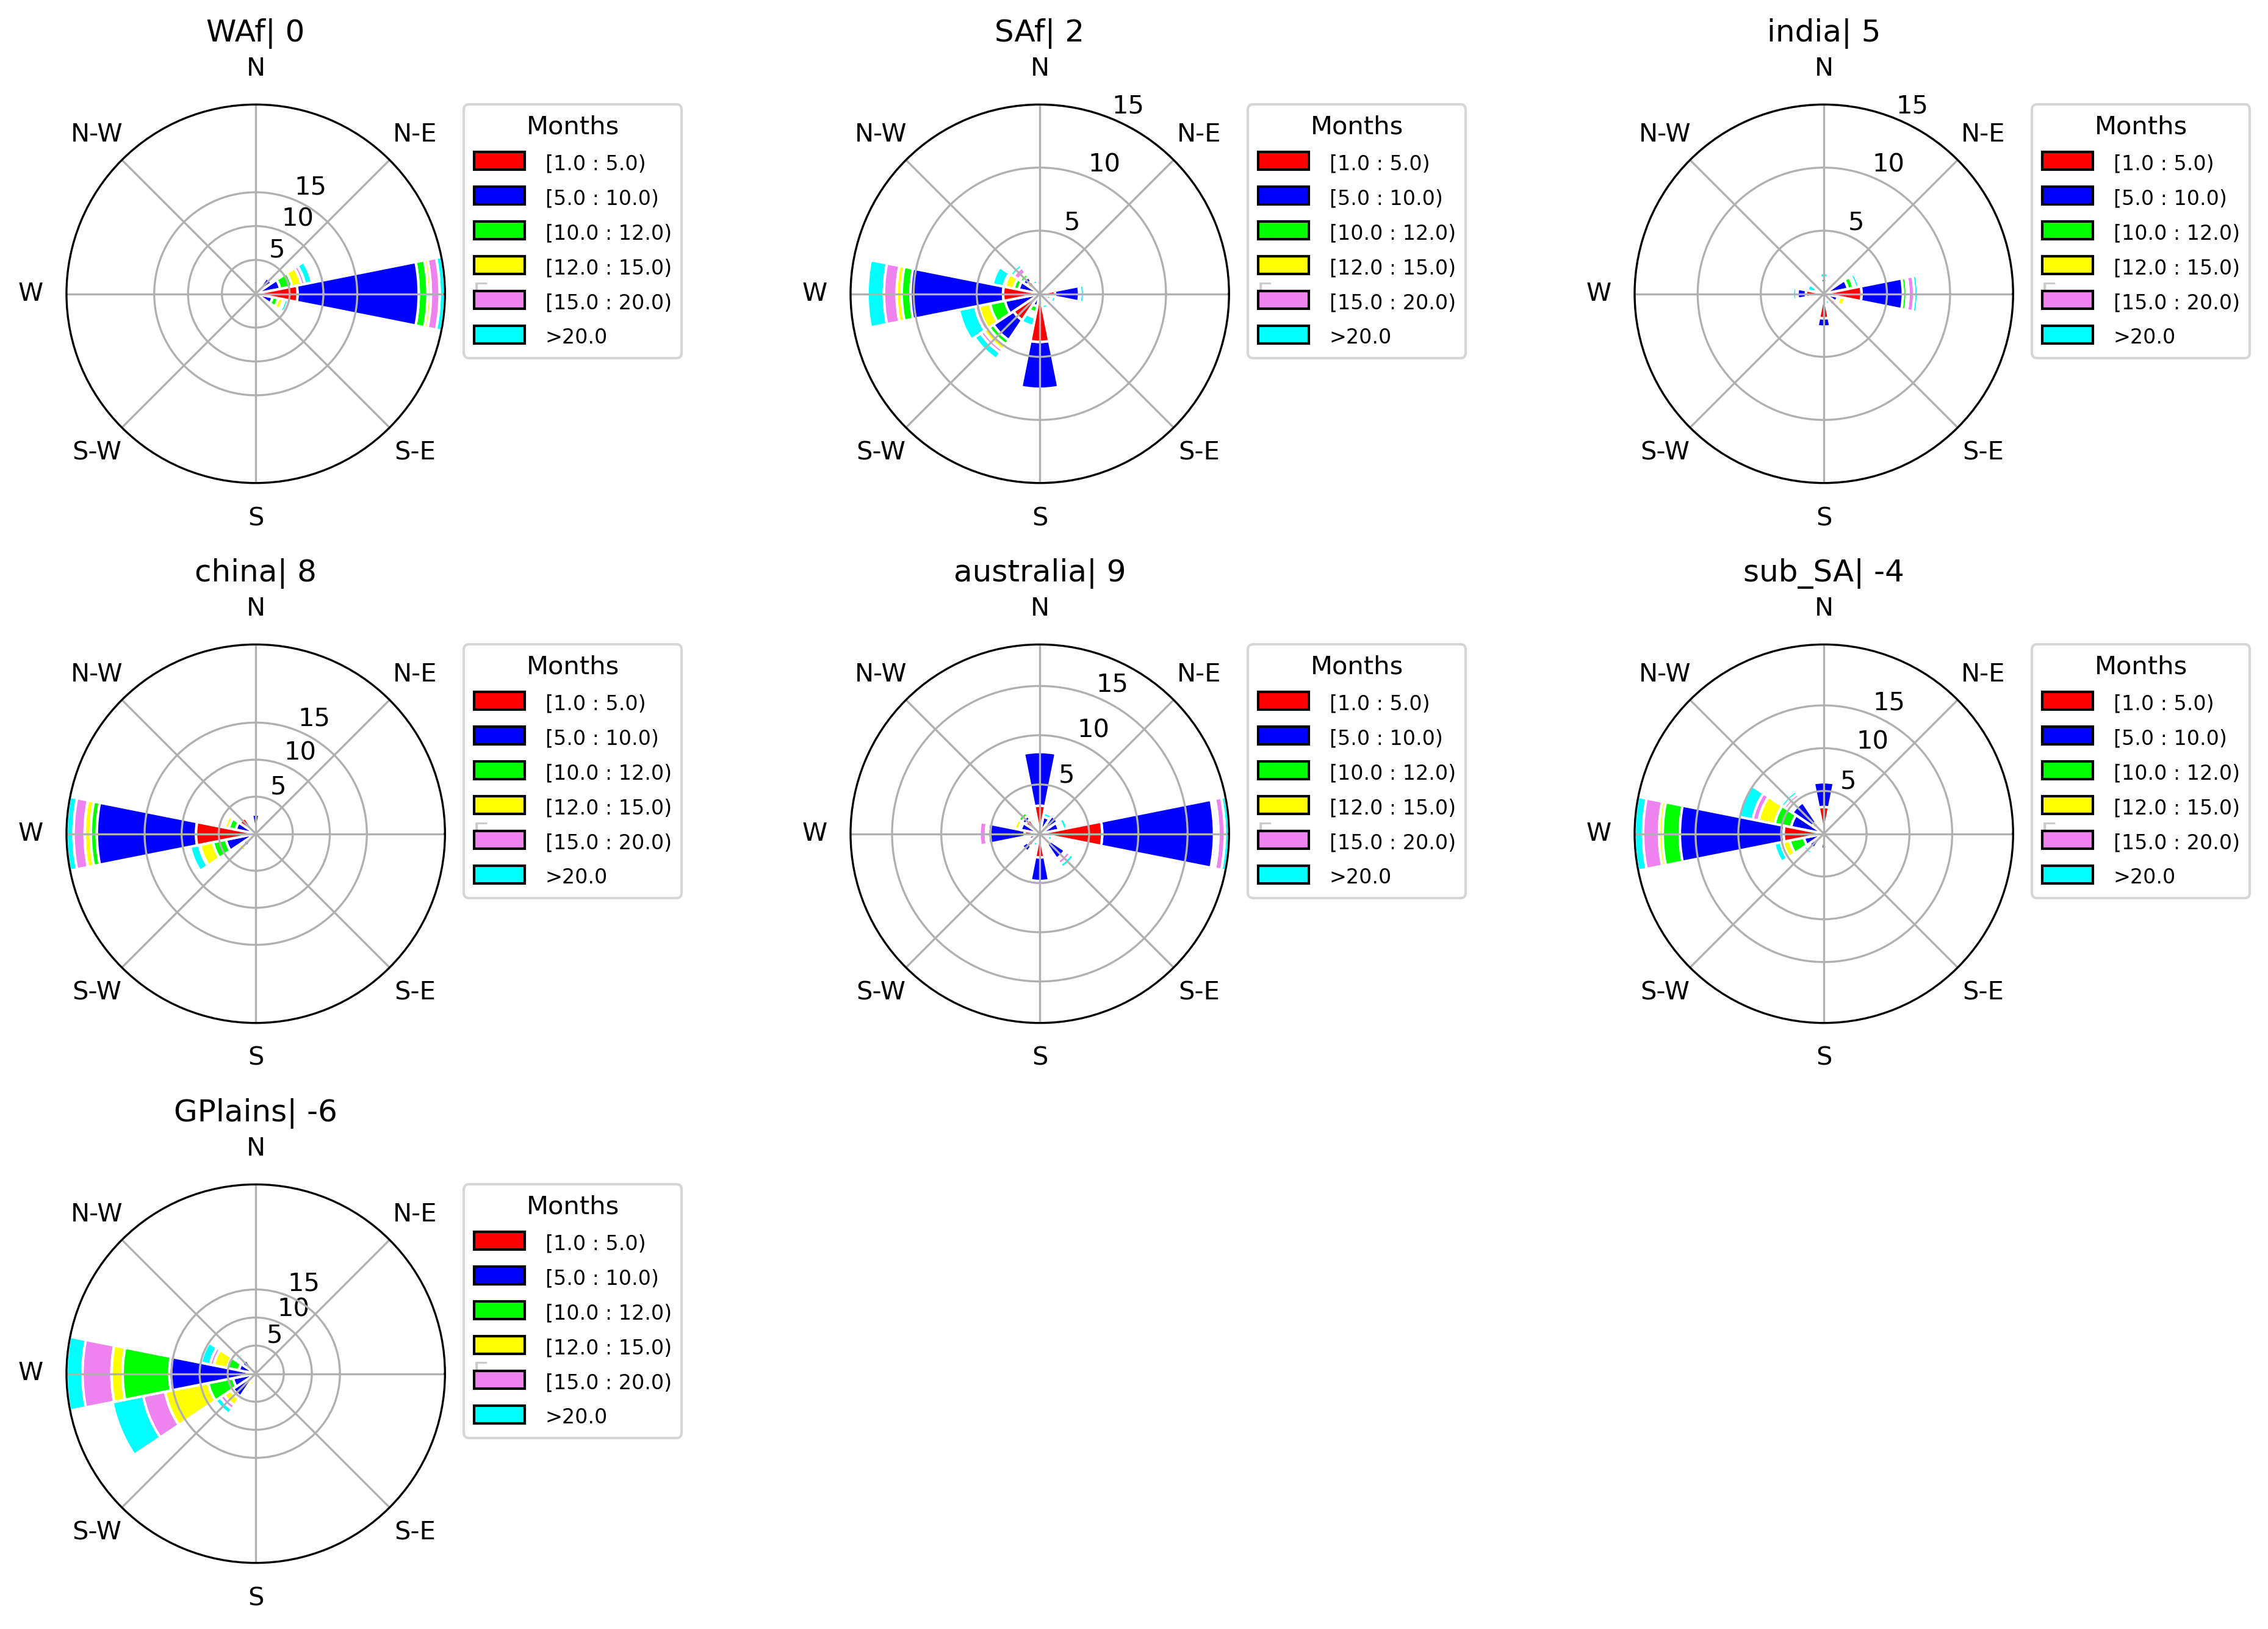

In [38]:
f= plt.figure(figsize=(13,9), dpi=300)
maxval = [45,30,25,40,30,35,40]

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1,  projection='windrose')
    
    pick = (rdics[regs])
    #pick = pick[(pick['utc_month']>=11) | (pick['utc_month']<=2)]

    umean = (pick['movement_distance_x'])
    vmean = (pick['movement_distance_y'])
    
    ws, avg_wd = u_met.u_v_to_ws_wd(umean,vmean)
    
    direct = avg_wd
    
    #####################
    ws_array2 = ws * 1000 / 60 / 60 #np.array(wsin.flatten())
    wd_array2 = direct

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[1,5,10,12,15,20], colors=color_s[0:6])
    ax.set_yticks(np.arange(5, 20, step=5))
    ax.set_yticklabels(np.arange(5, 20, step=5))



    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
    ax.set_legend(title = 'Months', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/storm_direction_windrose.jpg')

/home/ck/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


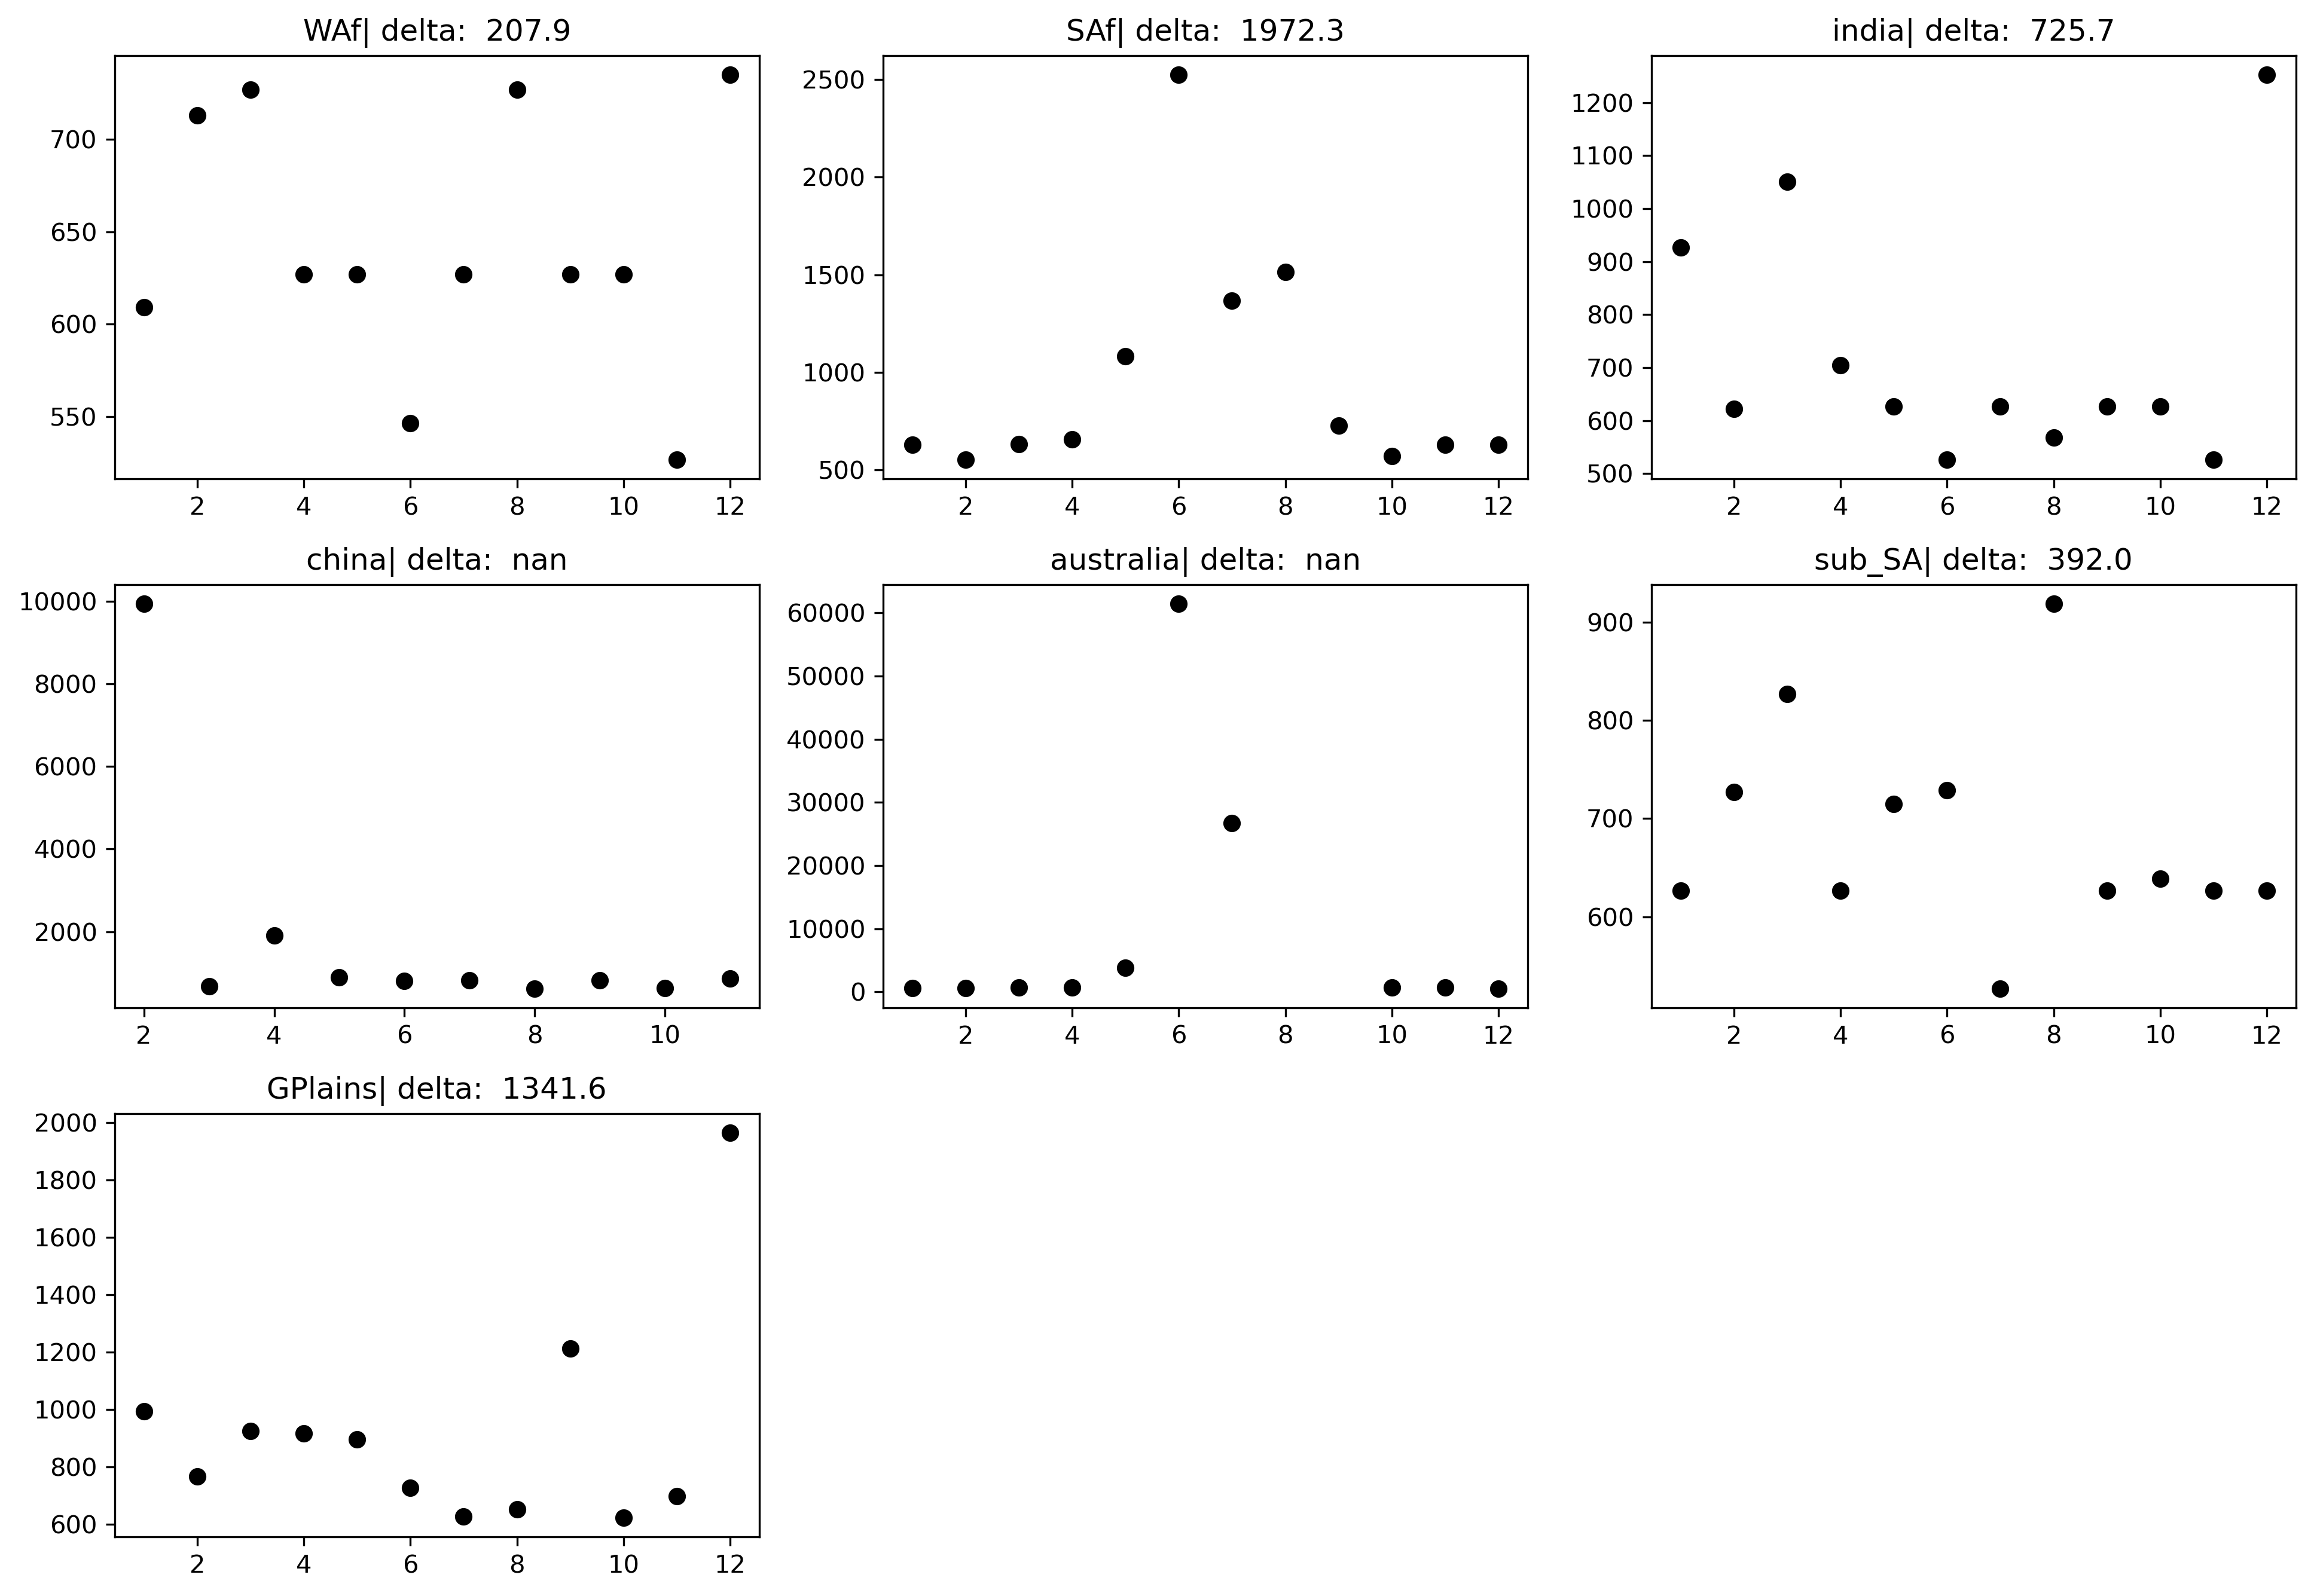

In [53]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['utc_month'] == m]
        meant =  np.nanpercentile(pickm['pf_area1'].values, 0.99)
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_area.jpg')

In [ ]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['meantb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_meant.jpg')

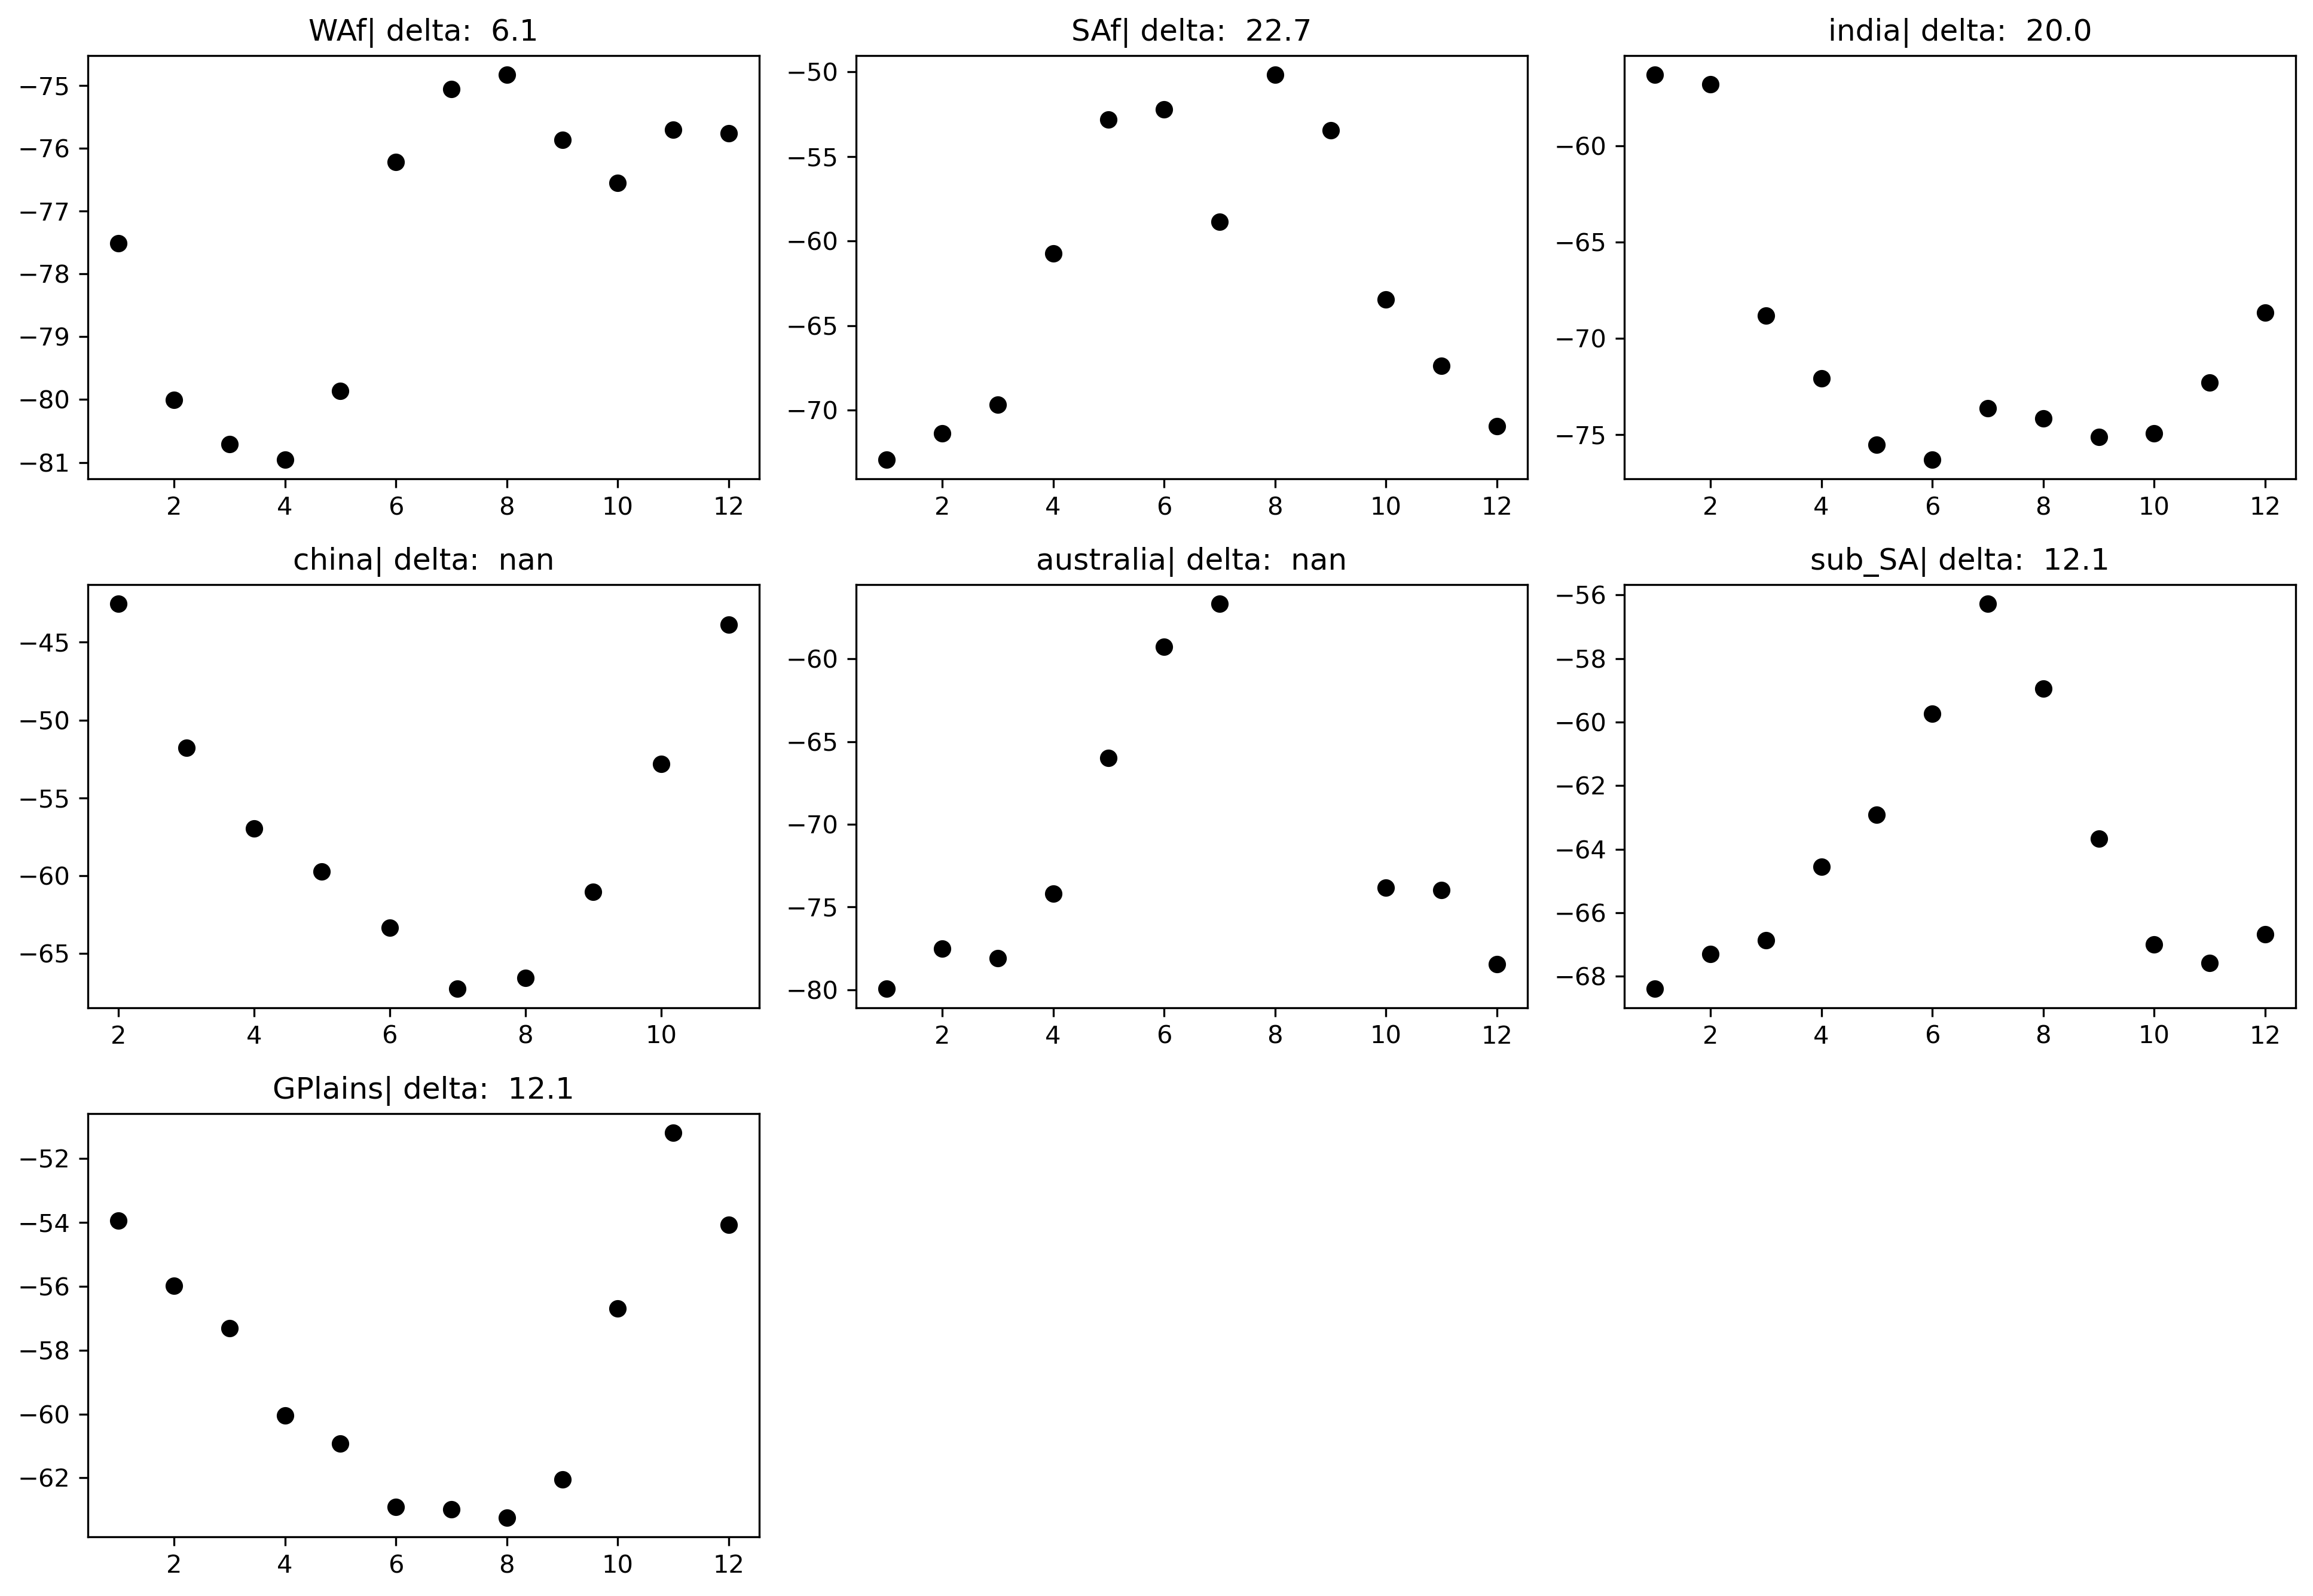

In [54]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['utc_month'] == m]
        meant =  pickm['corecold_mintb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint.jpg')

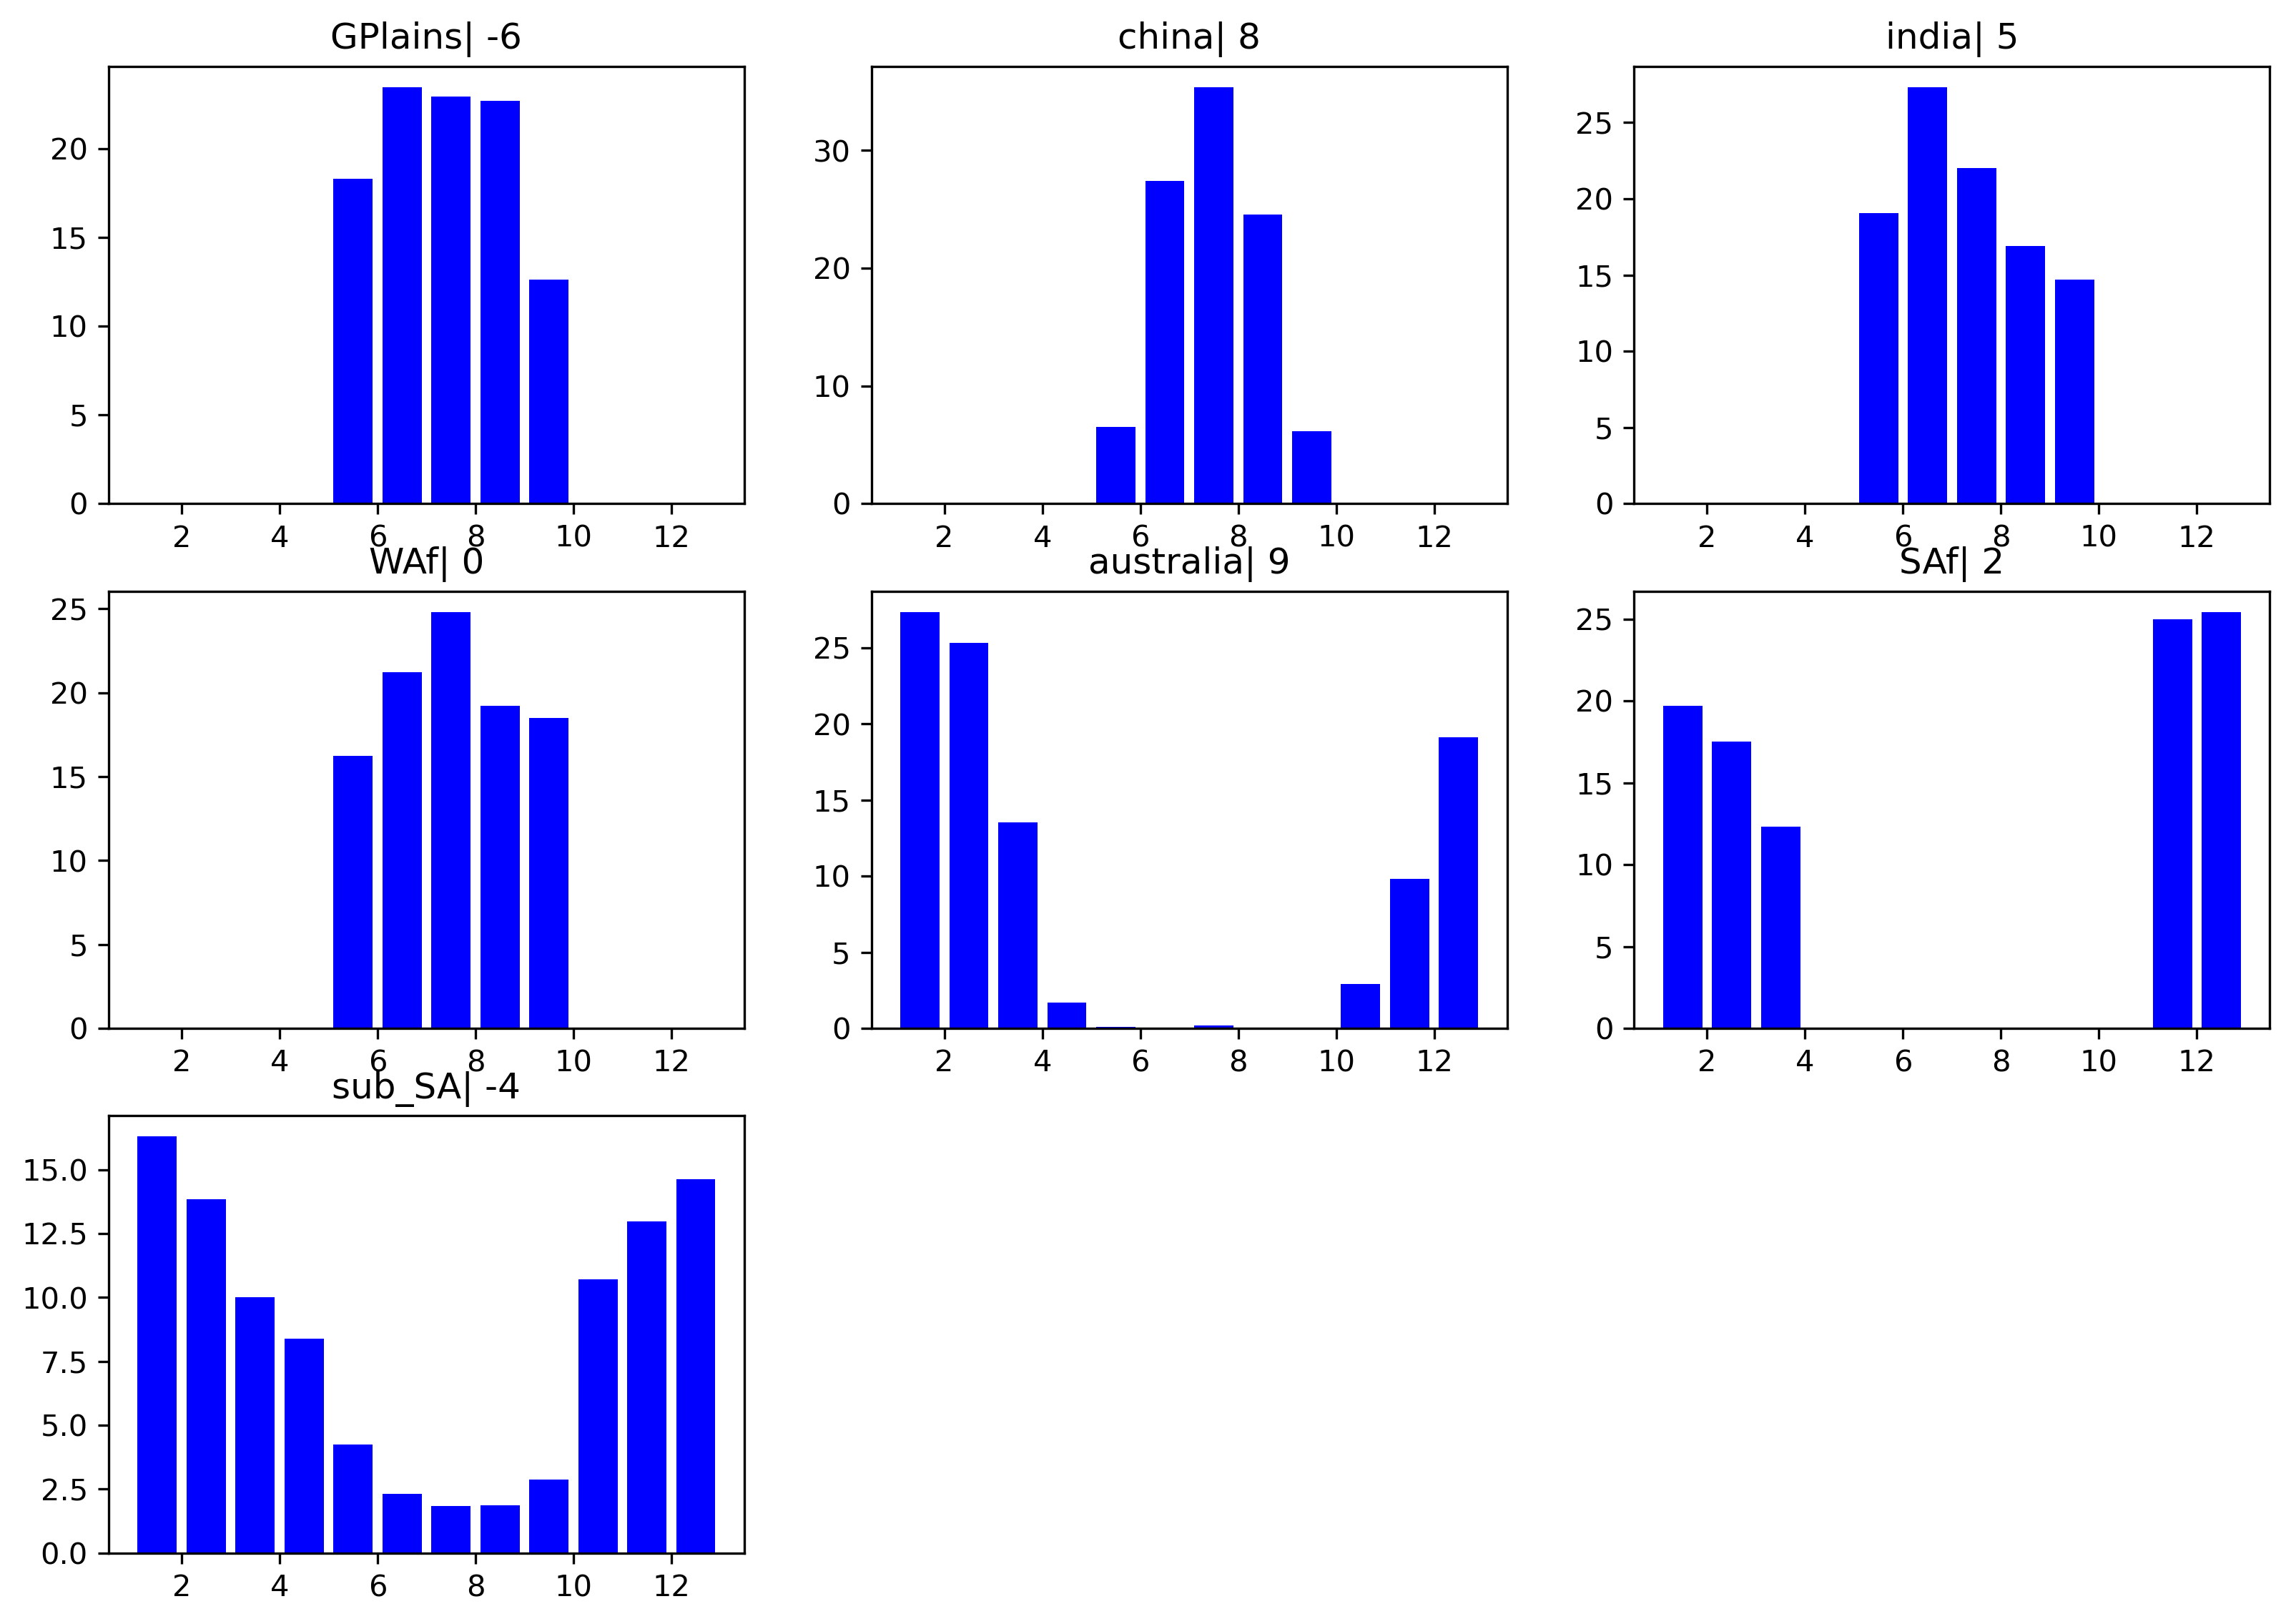

In [95]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['utc_month'], bins=np.arange(1,14))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_stormNB.jpg')

18
16
13
10
9
22
24


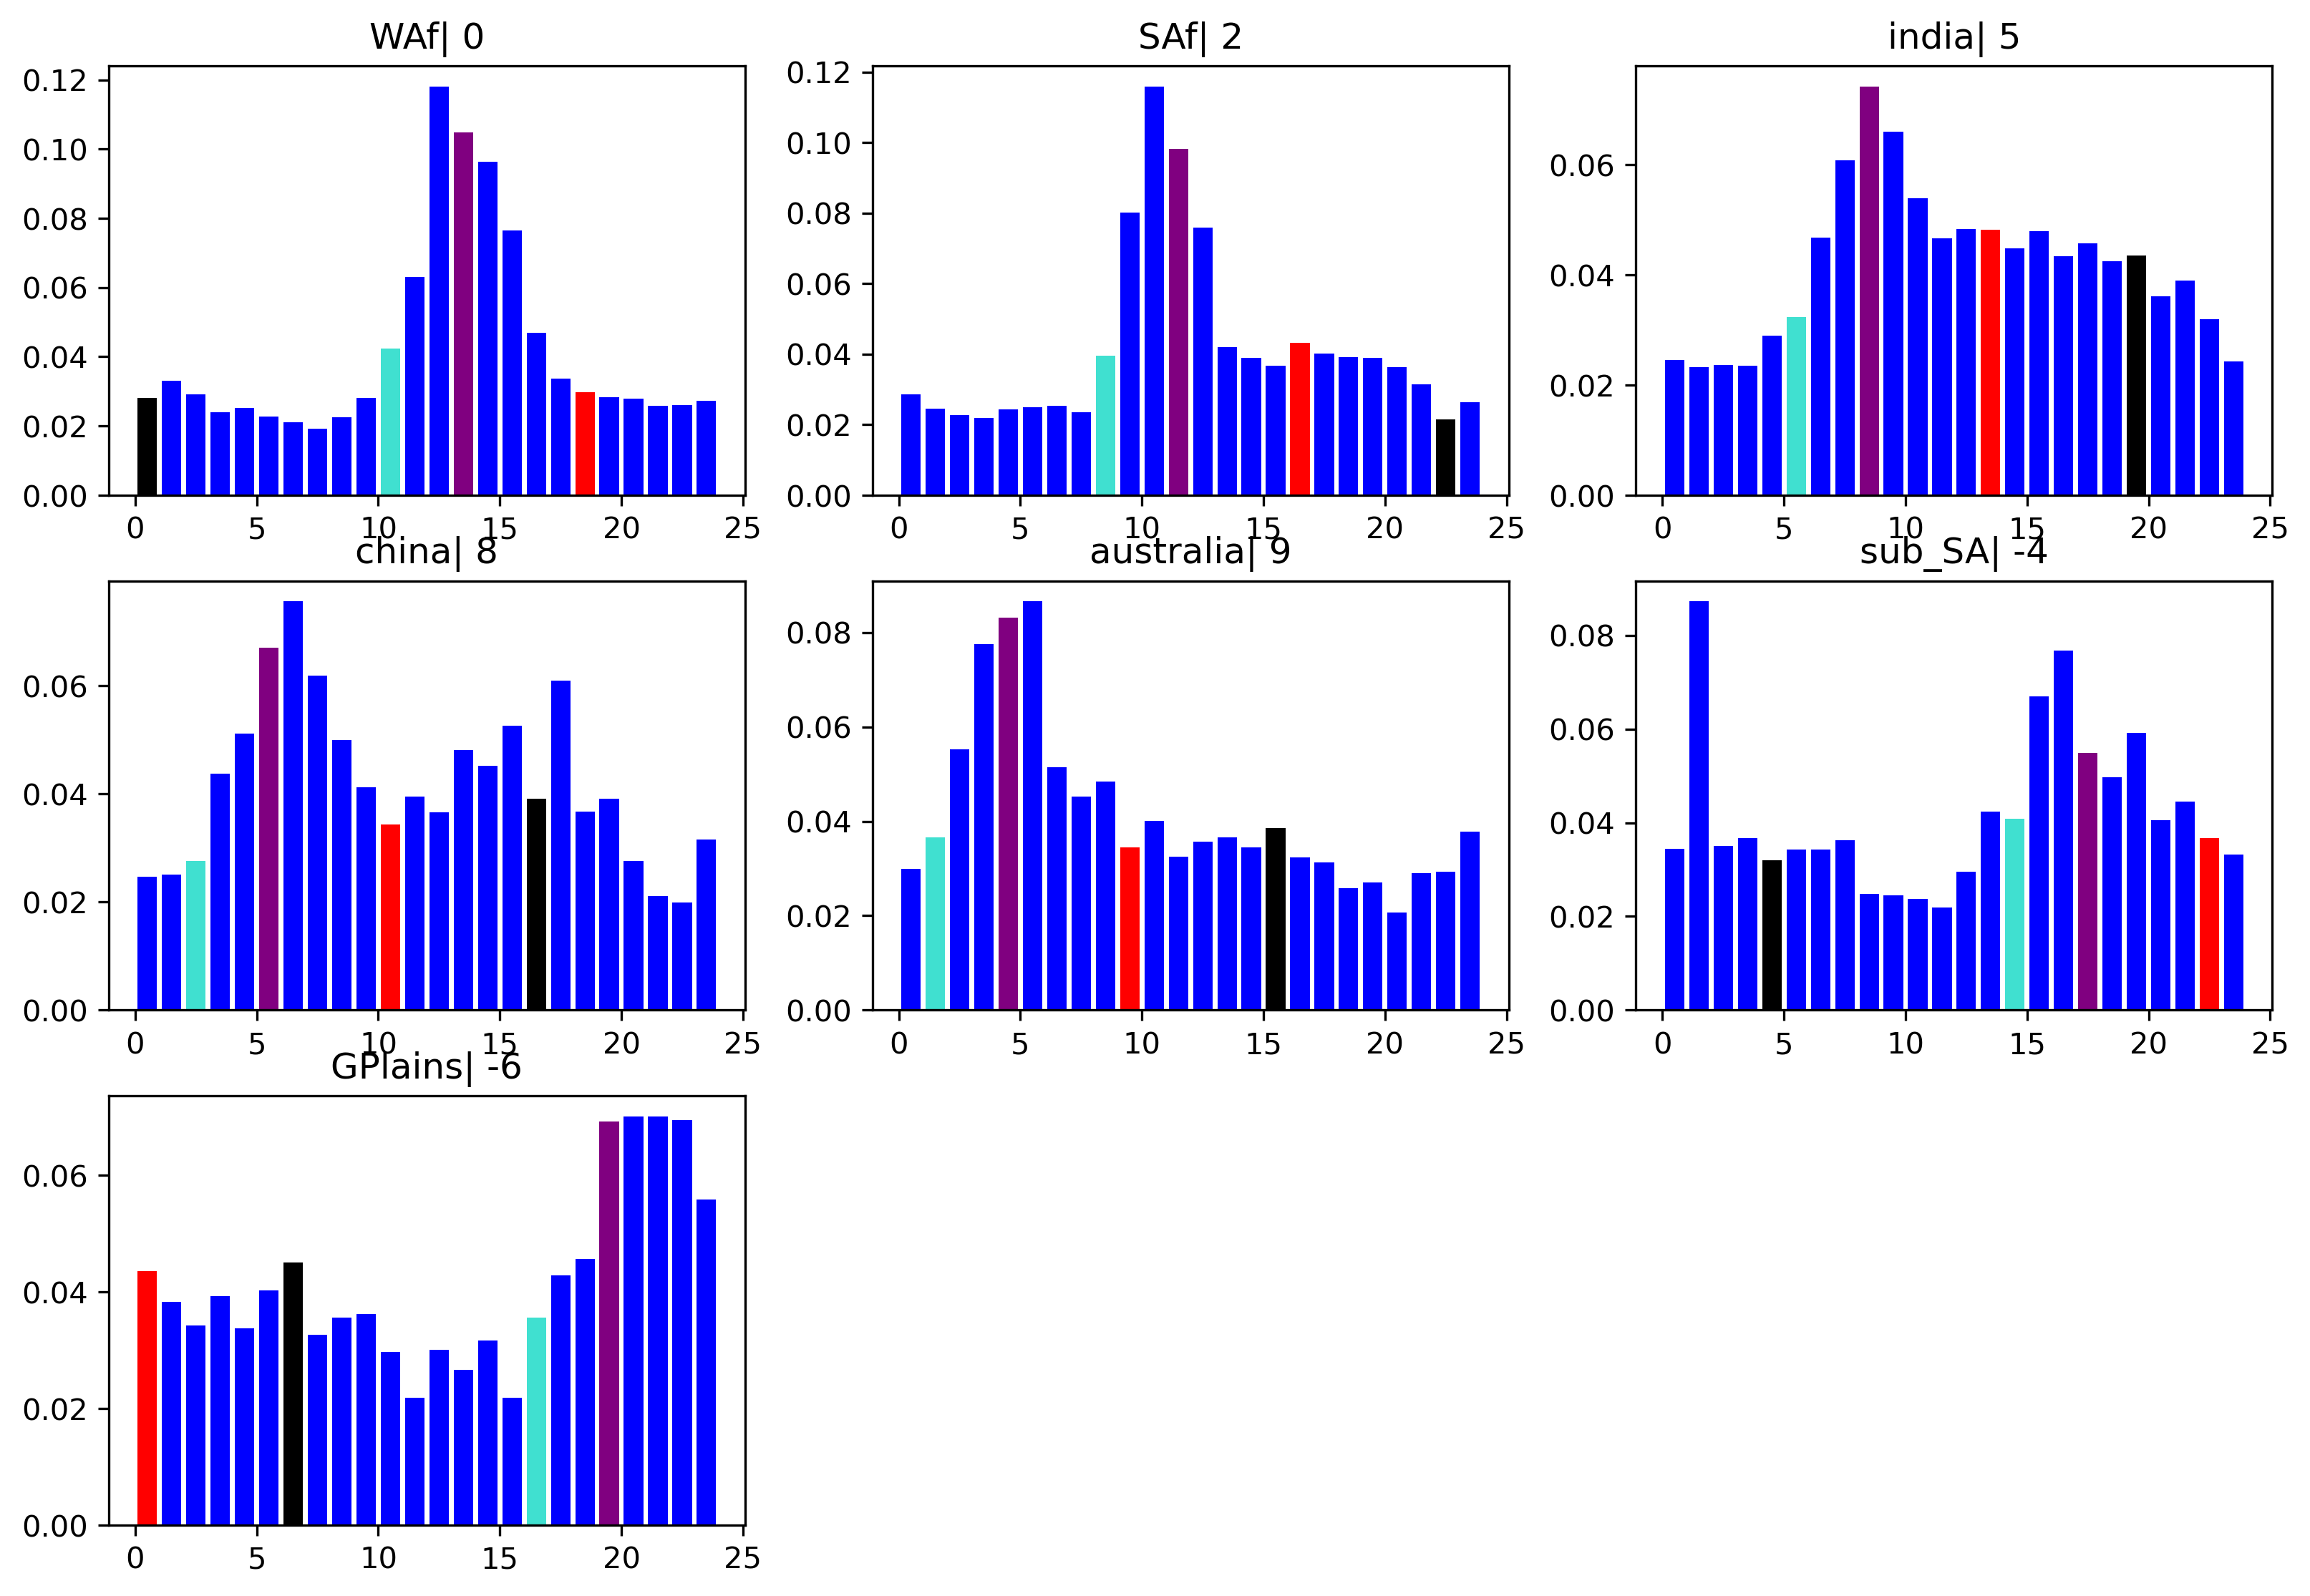

In [14]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['init_hour'], bins=np.arange(0,25))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
    ispos = int(np.where(mid_bin==18.5)[0])
    secpos = int(np.where(mid_bin==13.5)[0])
    firstpos = int(np.where(mid_bin==10.5)[0])
    thirdpos = int(np.where(mid_bin==0.5)[0])
    #minpos = ispos-(MREGIONS[regs])[2]
    #ipdb.set_trace()
    minpos = ispos-(MREGIONS[regs])[2]
    miinpos = firstpos - (MREGIONS[regs])[2]
    miiinpos = secpos - (MREGIONS[regs])[2]
    midnightpos = thirdpos - (MREGIONS[regs])[2]
    print(minpos)
    if minpos == 24:
        minpos=0
    
    colors[minpos] = 'r'
    colors[miinpos] = 'turquoise'
    colors[miiinpos] = 'purple'
    colors[midnightpos] = 'k'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))


In [107]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask] 
    sh = np.array(dic['shear'])[mask]  # 925-650 hPa shear
    umin = np.array(dic['u650'])[mask] # minimum 650hPa zonal wind 
    umax = np.array(dic['u925'])[mask] # maximum 925hPa zonal wind
    qq = np.array(dic['q925'])[mask]   # 925hPa spec humidity
    qup = np.array(dic['q650'])[mask]  # 650hPa spec humidity
    tlow = np.array(dic['t925'])[mask] # 925hPa temperature
    tt = np.array(dic['tmin'])[mask]   # minimum cloud top temperature
    ttm = np.array(dic['tmean'])[mask] # mean cloud top temperature
    month = np.array(dic['month'])[mask] 
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
   # minute = np.array(dic['minute'])[mask]
    day = np.array(dic['day'])[mask]
    date = np.array(dic['date'])[mask]
    area = np.array(dic['area'])[mask] # -50C storm area
    lat = np.array(dic['clat'])[mask] # location of minimum temperature
    lon = np.array(dic['clon'])[mask] # location of minimum temperature
    tcwv = np.array(dic['tcwv'])[mask] # total column water vapour
    rh = np.array(dic['rh925'])[mask] # 925hPa relative humidity
    #pall = np.array(dic['p'])[mask] # precipitation field within -50C cloud area


    obs_pcp = {
        'prcp' : pp,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
      #  'minute' : minute,
        'day' : day,
        'date' : date,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        'tcwv' : tcwv,
        'lat' : lat,
        'lon' : lon,
        #'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs



file_path = cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear*.p'
ds = glob.glob(file_path)

for ids, dss in enumerate(ds):
    data = pkl.load( open (dss, 'rb'))

    obs_gpmf_h = create_dic(data)
    if ids > 0:
        obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
    else:
        obs_gpmf = obs_gpmf_h

    del data
obs = obs_gpmf[obs_gpmf.prcp>5]
obs = pd.DataFrame(obs)

In [113]:
obs

,prcp,q925,q650,t925,shear,month,hour,year,day,date,area,tmin,rh,tcwv,lat,lon
0,7.657979,14.724190,4.140953,25.701318,6.841075,1,17,2007,28,2007-01-28 17:30:00,6325,-75.300844,65.575134,38.754639,7.356987,-1.882976
2,15.055140,14.724190,4.140953,25.701318,6.841075,1,18,2007,28,2007-01-28 18:30:00,11500,-69.499090,65.575134,38.754639,7.404227,-2.109662
3,5.943133,15.173133,4.058833,25.401636,5.112180,1,17,2007,29,2007-01-29 17:30:00,5975,-72.302664,68.002640,40.713509,6.358965,-0.271936
4,36.356035,16.458932,5.158984,23.484399,10.712464,1,17,2007,29,2007-01-29 17:30:00,9325,-63.217142,84.037170,44.086544,7.397655,-7.537494
5,7.684593,16.889343,4.339702,21.651758,11.828568,1,16,2007,31,2007-01-31 16:00:00,12050,-78.338737,96.645584,51.395821,5.408220,-7.923906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,12.618616,17.474011,4.316392,22.397241,9.893822,12,17,2008,17,2008-12-17 17:00:00,5650,-81.180647,95.546036,48.703316,5.587612,7.445095
2673,12.350243,16.071051,4.687850,23.121545,9.465675,12,17,2008,17,2008-12-17 17:00:00,5350,-76.991820,83.916214,48.527660,6.088415,-0.980034
2674,44.925868,16.082516,6.127825,20.624200,7.371384,12,17,2008,18,2008-12-18 17:00:00,55575,-83.975624,96.535057,52.119255,5.832236,-7.297491
2675,43.569980,16.232213,5.767504,22.369257,8.320564,12,17,2008,18,2008-12-18 17:00:00,13200,-77.568508,88.686577,53.128746,5.710372,-4.322611


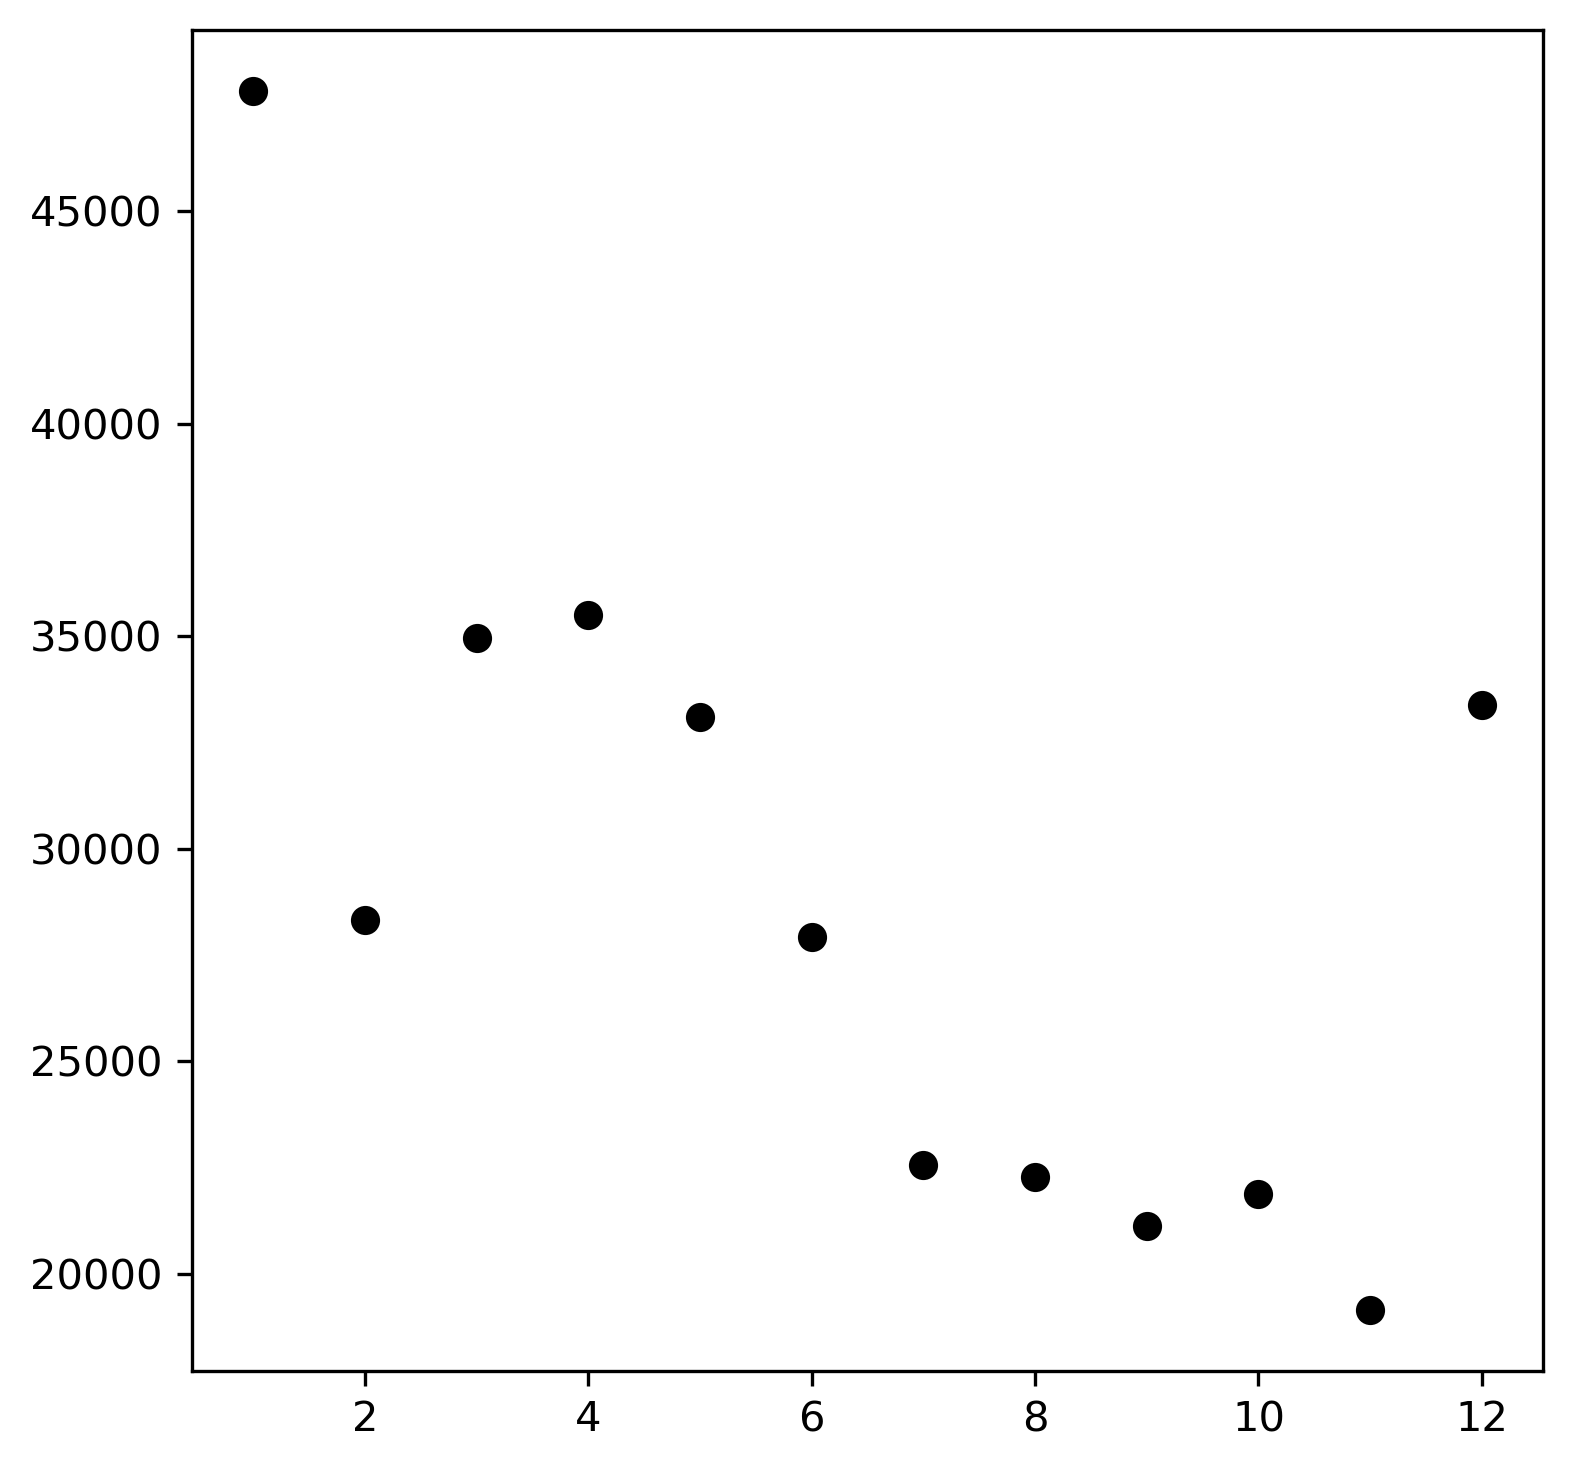

In [115]:
f= plt.figure(figsize=(10,5), dpi=300)

ax = f.add_subplot(1,2,1)
    
pick =obs
coll = []
for m in range(1,13):
    pickm = pick[pick['month'] == m]
    meant =  pickm['area'].mean()
    coll.append(meant)


ax.scatter(range(1,13),np.array(coll), color='k')
#ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint.jpg')

Text(0.5, 1.0, 'Storm area West Africa | 5000km2 min, -50C')

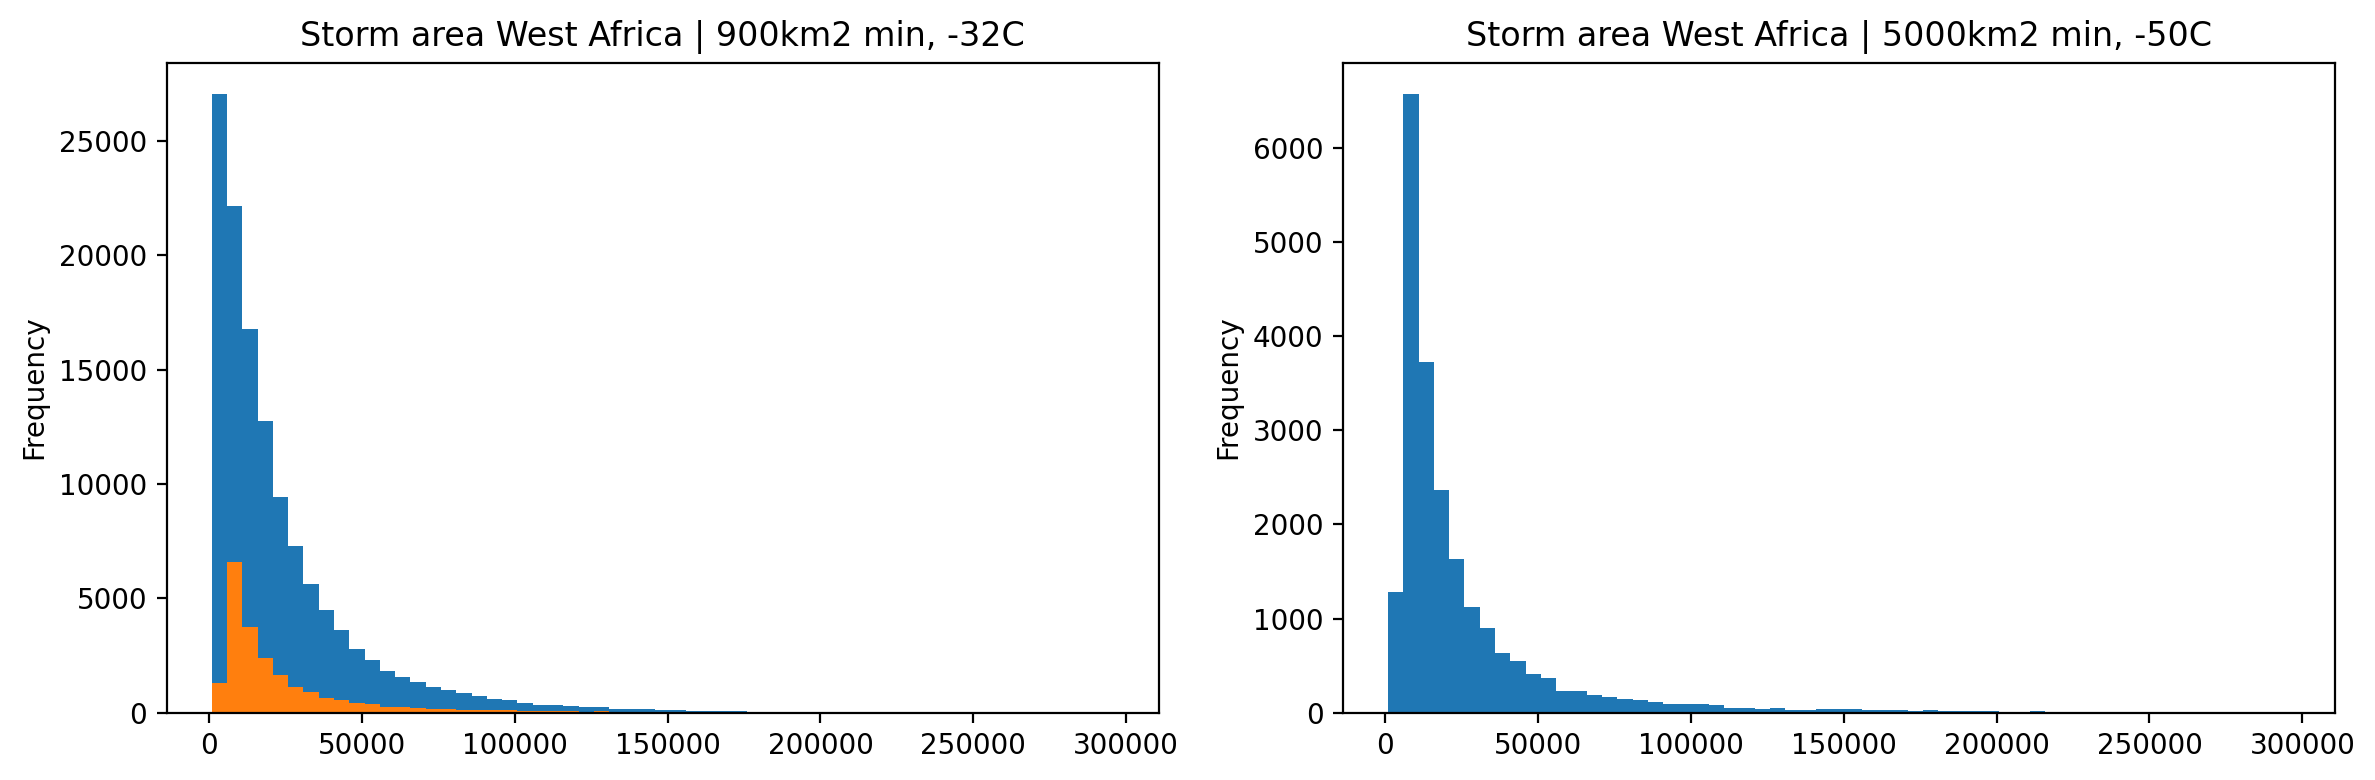

In [125]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(121)
(rdics['WAf'])['pf_area1'].plot.hist(bins=range(900,300000,5000)) # ccs_area, pf_area1
plt.title('Storm area West Africa | 900km2 min, -32C')

ax = f.add_subplot(122)
(obs['area']).plot.hist(bins=range(900,300000,5000))
plt.tight_layout()
plt.title('Storm area West Africa | 5000km2 min, -50C')

Text(0.5, 1.0, 'Storm area West Africa | 5000km2 min, -50C')

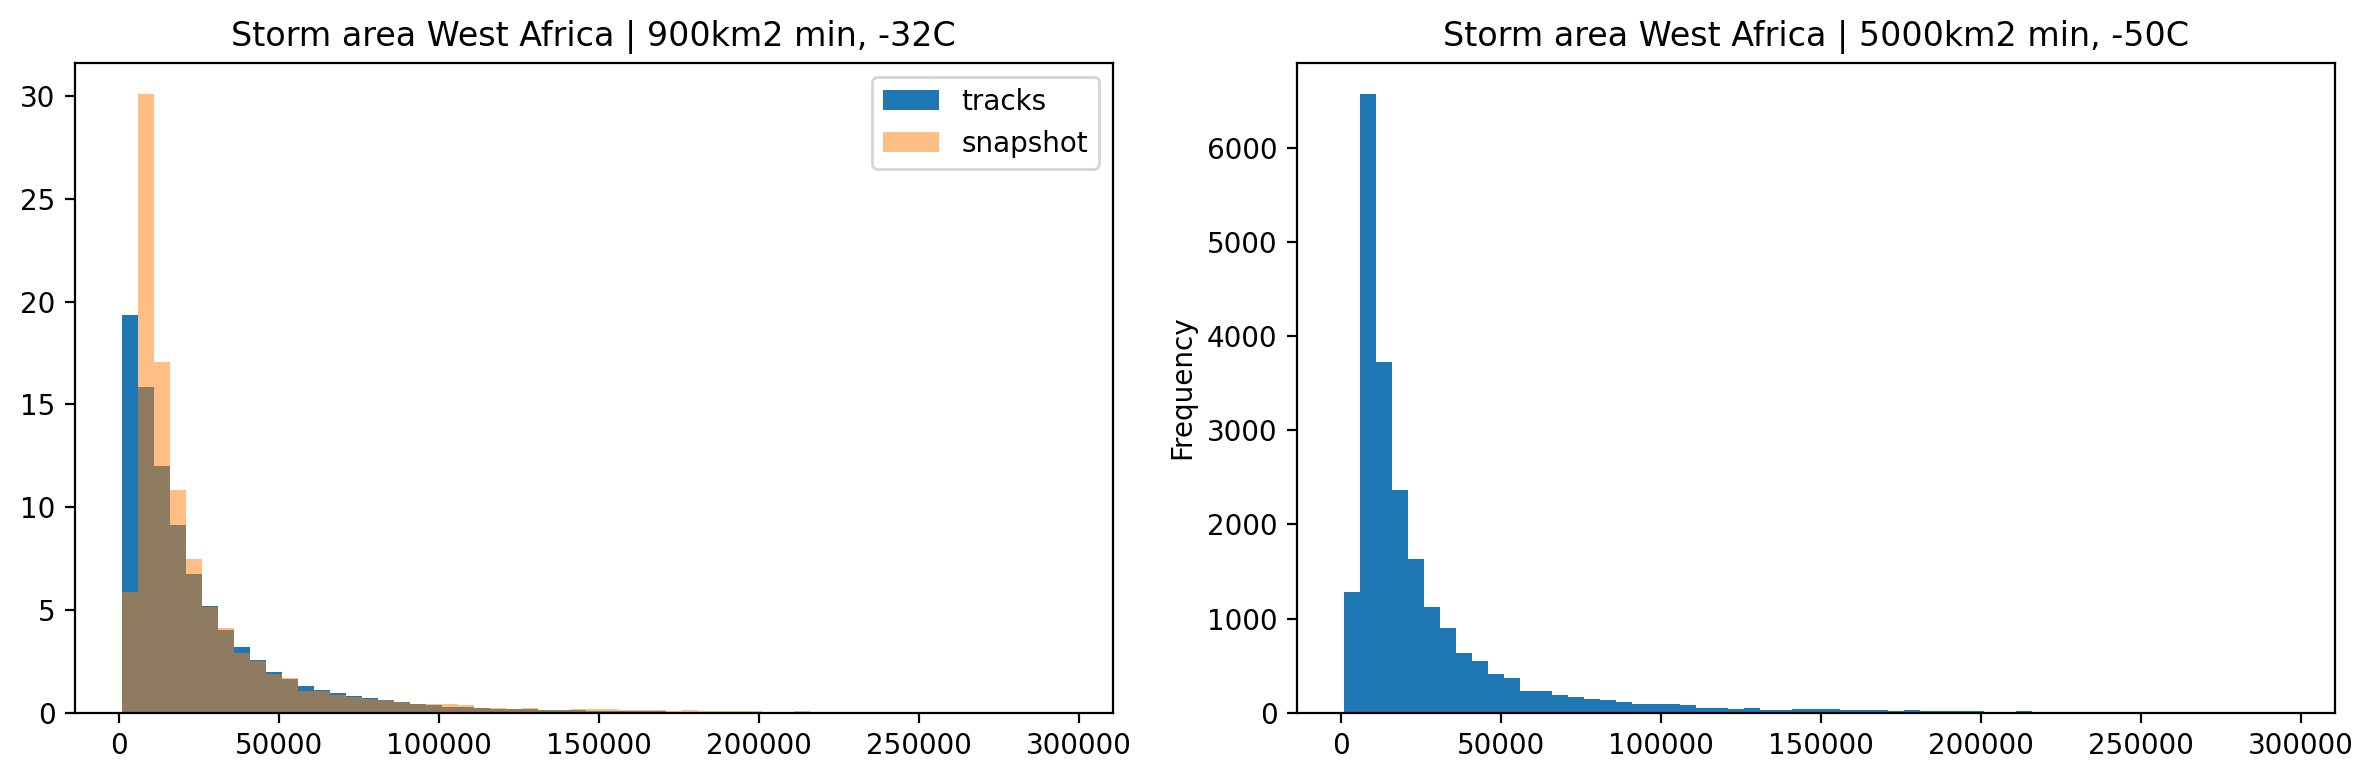

In [138]:
from utils import u_plot
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(121)
#hist, count, h = stats.histo_frequency((rdics['WAf'])['pf_area1'], bins=range(900,300000,5000))
u_plot.hist_freq(ax, rdics['WAf']['pf_area1'], bins=range(900,300000,5000), label='tracks') # ccs_area, pf_area1
u_plot.hist_freq(ax, obs['area'], bins=range(900,300000,5000), label='snapshot', alpha=0.5) # ccs_area, pf_area1
plt.title('Storm area West Africa | 900km2 min, -32C')
#ax.set_xlim(10000,200000)
plt.legend()

ax = f.add_subplot(122)
(obs['area']).plot.hist(bins=range(900,300000,5000))
plt.tight_layout()
plt.title('Storm area West Africa | 5000km2 min, -50C')